In [1]:
import pandas as pd
import re
import numpy as np
import datetime as dt 
import os
from fuzzywuzzy import fuzz
import ast
from nltk import ngrams
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pkg_resources
from symspellpy.symspellpy import SymSpell, Verbosity
import numpy as np
from textblob import TextBlob
import matplotlib as mpl
from scipy.signal import savgol_filter    

#### Read csv file containing results from matching food subreddit titles with USDA nutritional informaton

In [21]:
df_combined_1 = pd.read_csv('upgraded_results_for_timeseries_analysis_with_dumps_and_missing_data.csv')

In [231]:
df_combined_1 = df_combined_1.drop(columns=['Unnamed: 0'])

In [232]:
len(df_combined_1)

590731

In [9]:
df_combined_1.head()

Unnamed: 0                                    food_post_title  \
0           0   cheeseburger with minced garlic and jalapeo c...   
1           1                         torta di pera e ciaccolato   
2           2   delicious cinnamon buns twiced proved icing w...   
3           3                           louisiana crawfish boil    
4           4               whole s or 99 cents store taste test   

        food_post_date                            closest_match_from_usda  \
0  2018-03-31 00:02:47  ['roast beef submarine sandwich with cheese le...   
1  2018-03-31 00:14:11  ['bread pound cake type pan de torta salvadora...   
2  2018-03-31 00:17:04  ['pie cherry made with cream cheese and sour c...   
3  2018-03-31 00:19:08  ['beef pot roast braised or boiled ns as to fa...   
4  2018-03-31 00:23:21  ['milk whole', 'milk low sodium whole', 'milk ...   

   calories  protein   fat  sugar  carbohydrates  sodium  cholesterol  fiber  \
0    241.26    12.27  2.76   4.73          18.88  529.31        35.67   1.15   
1    217.68     3.65  8.18   7.24          10.61  414.97        21.10   0.36   
2    184.37     8.49  2.07   5.81          17.22  337.42        44.19   0.75   
3    153.58    11.32  1.37   1.26          12.40  298.77        63.26   1.29   
4     89.70     4.62  0.22   7.43          10.24   67.03        25.69   0.51   

   protein_cals  fat_cals  carb_cals  \
0         49.09     24.86      75.52   
1         14.59     73.64      42.44   
2         33.97     18.61      68.87   
3         45.30     12.35      49.59   
4         18.49      1.99      40.96   

                               index_of_usda_in_json   just_date  
0  [2315, 2373, 2379, 2381, 2383, 2420, 10359, 55...  2018-03-31  
1  [7098, 3, 73, 74, 75, 76, 77, 78, 79, 279, 280...  2018-03-31  
2  [3590, 7511, 1676, 1679, 1714, 1730, 1746, 175...  2018-03-31  
3  [688, 689, 690, 827, 848, 1572, 1583, 1598, 16...  2018-03-31  
4  [2, 3, 4, 15, 19, 21, 23, 27, 48, 52, 56, 60, ...  2018-03-31

In [22]:
df_combined_1['just_date'] = df_combined_1['food_post_date'].apply(lambda x: x[:10])

#### Split data into two dataframes - 1. matches found, 2. no matches found

In [27]:
df_combined_2 = df_combined_1[df_combined_1['closest_match_from_usda']!='[]']

In [20]:
df_combined_3 = df_combined_1[df_combined_1['closest_match_from_usda']=='[]']

In [236]:
len(df_combined_3)

44266

In [237]:
df_combined_3 = df_combined_3.dropna(subset=['food_post_title'])

In [238]:
len(df_combined_3)

42786

In [239]:
len(df_combined_2)

546465

#### No matches were found for 7.49% of the dataset

In [240]:
print(str(round(len(df_combined_1[df_combined_1['closest_match_from_usda']=='[]'])/len(df_combined_1)*100 , 2)) + ' %')

7.49 %


In [211]:
df_combined_2['closest_match_from_usda'] = df_combined_2['closest_match_from_usda'].apply(lambda x: ast.literal_eval(x))

C:\Users\melik\AppData\Local\Temp\ipykernel_1528\1939661125.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined_2['closest_match_from_usda'] = df_combined_2['closest_match_from_usda'].apply(lambda x: ast.literal_eval(x))


In [212]:
df_combined_2['list_len'] = df_combined_2['closest_match_from_usda'].apply(lambda x: len(x))

C:\Users\melik\AppData\Local\Temp\ipykernel_1528\2561404697.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined_2['list_len'] = df_combined_2['closest_match_from_usda'].apply(lambda x: len(x))


In [241]:
df_combined_2.iloc[-1]

food_post_title                                       honey cake aka medovik
food_post_date                                           2021-04-13 23:59:08
closest_match_from_usda    ['almonds honey roasted', 'cashews honey roast...
calories                                                              396.61
protein                                                                 8.12
fat                                                                     6.65
sugar                                                                  21.88
carbohydrates                                                          55.97
sodium                                                                430.27
cholesterol                                                             8.82
fiber                                                                   5.45
protein_cals                                                           32.33
fat_cals                                                               59.85

In [26]:
df_combined_2.head()

Unnamed: 0                                    food_post_title  \
just_date                                                                   
2018-03-31           0   cheeseburger with minced garlic and jalapeo c...   
2018-03-31           1                         torta di pera e ciaccolato   
2018-03-31           2   delicious cinnamon buns twiced proved icing w...   
2018-03-31           3                           louisiana crawfish boil    
2018-03-31           4               whole s or 99 cents store taste test   

                 food_post_date  \
just_date                         
2018-03-31  2018-03-31 00:02:47   
2018-03-31  2018-03-31 00:14:11   
2018-03-31  2018-03-31 00:17:04   
2018-03-31  2018-03-31 00:19:08   
2018-03-31  2018-03-31 00:23:21   

                                      closest_match_from_usda  calories  \
just_date                                                                 
2018-03-31  ['roast beef submarine sandwich with cheese le...    241.26   
2018-03-31  ['bread pound cake type pan de torta salvadora...    217.68   
2018-03-31  ['pie cherry made with cream cheese and sour c...    184.37   
2018-03-31  ['beef pot roast braised or boiled ns as to fa...    153.58   
2018-03-31  ['milk whole', 'milk low sodium whole', 'milk ...     89.70   

            protein   fat  sugar  carbohydrates  sodium  cholesterol  fiber  \
just_date                                                                     
2018-03-31    12.27  2.76   4.73          18.88  529.31        35.67   1.15   
2018-03-31     3.65  8.18   7.24          10.61  414.97        21.10   0.36   
2018-03-31     8.49  2.07   5.81          17.22  337.42        44.19   0.75   
2018-03-31    11.32  1.37   1.26          12.40  298.77        63.26   1.29   
2018-03-31     4.62  0.22   7.43          10.24   67.03        25.69   0.51   

            protein_cals  fat_cals  carb_cals  \
just_date                                       
2018-03-31         49.09     24.86      75.52   
2018-03-31         14.59     73.64      42.44   
2018-03-31         33.97     18.61      68.87   
2018-03-31         45.30     12.35      49.59   
2018-03-31         18.49      1.99      40.96   

                                        index_of_usda_in_json  
just_date                                                      
2018-03-31  [2315, 2373, 2379, 2381, 2383, 2420, 10359, 55...  
2018-03-31  [7098, 3, 73, 74, 75, 76, 77, 78, 79, 279, 280...  
2018-03-31  [3590, 7511, 1676, 1679, 1714, 1730, 1746, 175...  
2018-03-31  [688, 689, 690, 827, 848, 1572, 1583, 1598, 16...  
2018-03-31  [2, 3, 4, 15, 19, 21, 23, 27, 48, 52, 56, 60, ...

In [28]:
df_combined_2['just_date'] = pd.to_datetime(df_combined_2['just_date'])

C:\Users\melik\AppData\Local\Temp\ipykernel_27428\2560171452.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined_2['just_date'] = pd.to_datetime(df_combined_2['just_date'])


### Creating a function that plots nutritional timeseries for data with given dataframe, frequency and color of the plot

In [29]:
def plot_all_nutritional_values(dataframe, frequency, color_t):
    
    # PLOT TOTAL CALORIES
    means_calories_total = dataframe.reset_index().groupby(pd.Grouper(key='just_date', freq=frequency))['calories'].mean()
    plt.figure(figsize=(15,8))
    plt.title('Calories total')
    means_calories_total.plot(color=color_t)
    plt.show()
    
    # PLOT CALORIES FROM PROTEIN
    means_calories_protein = dataframe.reset_index().groupby(pd.Grouper(key='just_date', freq=frequency))['protein_cals'].mean()
    plt.figure(figsize=(15,8))
    plt.title('Calories protein')
    means_calories_protein.plot(color=color_t)
    plt.show()
    
    # PLOT CALORIES FROM FAT
    means_calories_fat = dataframe.reset_index().groupby(pd.Grouper(key='just_date', freq=frequency))['fat_cals'].mean()
    plt.figure(figsize=(15,8))
    plt.title('Calories fat')
    means_calories_fat.plot(color=color_t)
    plt.show()
    
    # PLOT CALORIES FROM CARBOHYDRATES
    means_calories_carbs = dataframe.reset_index().groupby(pd.Grouper(key='just_date', freq=frequency))['carb_cals'].mean()
    plt.figure(figsize=(15,8))
    plt.title('Calories carbohydrates')
    means_calories_carbs.plot(color=color_t)
    plt.show()
    
    # PLOT SUGAR VALUES IN G
    means_sugar = dataframe.reset_index().groupby(pd.Grouper(key='just_date', freq=frequency))['sugar'].mean()
    plt.figure(figsize=(15,8))
    plt.title('Sugar')
    means_sugar.plot(color=color_t)
    plt.show()
    
    # PLOT FIBER VALUES IN G
    means_fiber = dataframe.reset_index().groupby(pd.Grouper(key='just_date', freq=frequency))['fiber'].mean()
    plt.figure(figsize=(15,8))
    plt.title('Fiber')
    means_fiber.plot(color=color_t)
    plt.show()
    
    # PLOT SODIUM IN MG
    means_sodium = dataframe.reset_index().groupby(pd.Grouper(key='just_date', freq=frequency))['sodium'].mean()
    plt.figure(figsize=(15,8))
    plt.title('Sodium')
    means_sodium.plot(color=color_t)
    plt.show()
    
    # PLOT CHOLESTEROL IN MG
    means_cholesterol = dataframe.reset_index().groupby(pd.Grouper(key='just_date', freq=frequency))['cholesterol'].mean()
    plt.figure(figsize=(15,8))
    plt.title('Cholesterol')
    means_cholesterol.plot(color=color_t)
    plt.show()
    

In [30]:
def plot_all_nutritional_values_with_moving_average(dataframe, frequency, color_t, number):
    
    # PLOT TOTAL CALORIES
    calories_mean_mov_avg = dataframe.reset_index().groupby(pd.Grouper(key='just_date', freq=frequency))['calories'].mean().rolling(number).mean()
    plt.figure(figsize=(15,8))
    plt.title('Calories total with mov_avg')
    calories_mean_mov_avg.plot(color=color_t)
    plt.show()
    
    # PLOT CALORIES FROM PROTEIN
    calories_protein_mov_avg = dataframe.reset_index().groupby(pd.Grouper(key='just_date', freq=frequency))['protein_cals'].mean().rolling(number).mean()
    plt.figure(figsize=(15,8))
    plt.title('Calories protein with mov_avg')
    calories_protein_mov_avg.plot(color=color_t)
    plt.show()
    
    # PLOT CALORIES FROM FAT
    calories_fat_mov_avg = dataframe.reset_index().groupby(pd.Grouper(key='just_date', freq=frequency))['fat_cals'].mean().rolling(number).mean()
    plt.figure(figsize=(15,8))
    plt.title('Calories fat with mov_avg')
    calories_fat_mov_avg.plot(color=color_t)
    plt.show()
    
    # PLOT CALORIES FROM CARBOHYDRATES
    calories_carbs_mov_avg = dataframe.reset_index().groupby(pd.Grouper(key='just_date', freq=frequency))['carb_cals'].mean().rolling(number).mean()
    plt.figure(figsize=(15,8))
    plt.title('Calories carbohydrates with mov_avg')
    calories_carbs_mov_avg.plot(color=color_t)
    plt.show()
    
    # PLOT SUGAR VALUES IN G
    sugar_mov_avg = dataframe.reset_index().groupby(pd.Grouper(key='just_date', freq=frequency))['sugar'].mean().rolling(number).mean()
    plt.figure(figsize=(15,8))
    plt.title('Sugar with mov_avg')
    sugar_mov_avg.plot(color=color_t)
    plt.show()
    
    # PLOT FIBER VALUES IN G
    fiber_mov_avg = dataframe.reset_index().groupby(pd.Grouper(key='just_date', freq=frequency))['fiber'].mean().rolling(number).mean()
    plt.figure(figsize=(15,8))
    plt.title('Fiber with mov_avg')
    fiber_mov_avg.plot(color=color_t)
    plt.show()
    
    # PLOT SODIUM IN MG
    sodium_mov_avg = dataframe.reset_index().groupby(pd.Grouper(key='just_date', freq=frequency))['sodium'].mean().rolling(number).mean()
    plt.figure(figsize=(15,8))
    plt.title('Sodium with mov_avg')
    sodium_mov_avg.plot(color=color_t)
    plt.show()
    
    # PLOT CHOLESTEROL IN MG
    cholesterol_mov_avg = dataframe.reset_index().groupby(pd.Grouper(key='just_date', freq=frequency))['cholesterol'].mean().rolling(number).mean()
    plt.figure(figsize=(15,8))
    plt.title('Cholesterol with mov_avg')
    cholesterol_mov_avg.plot(color=color_t)
    plt.show()

### Plotting nutritional timeseries for all 4 years (from March 2018 until March 2022)

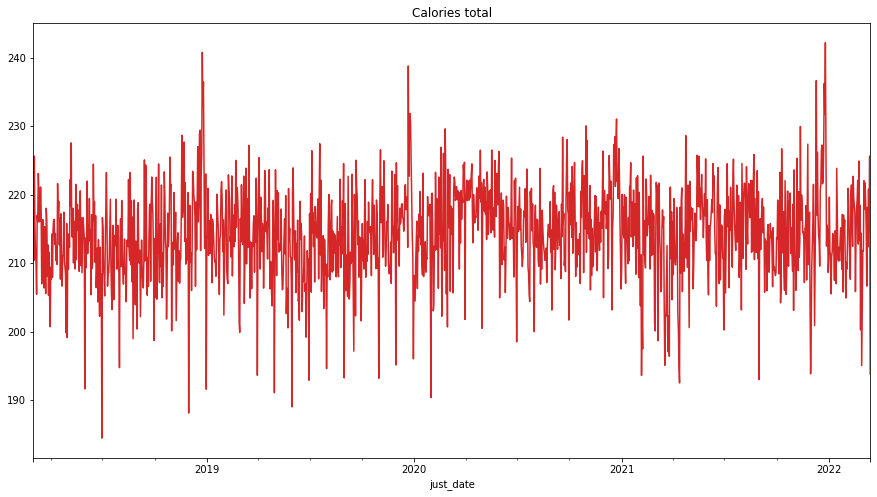

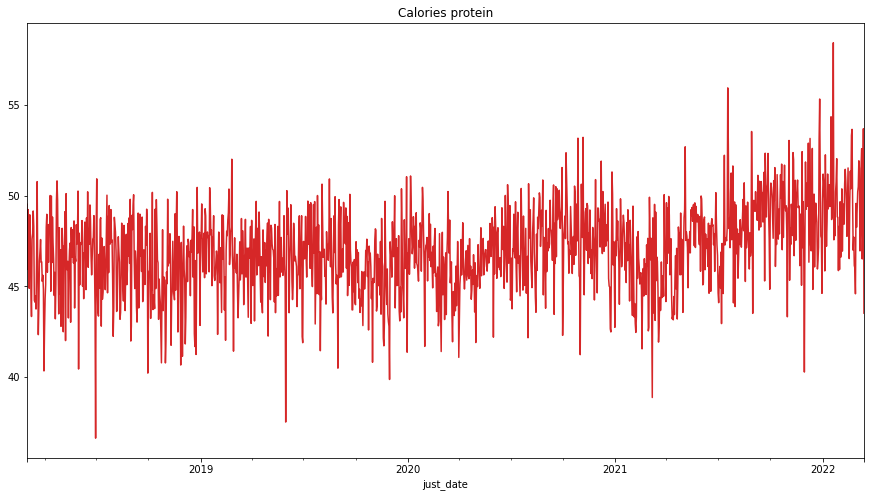

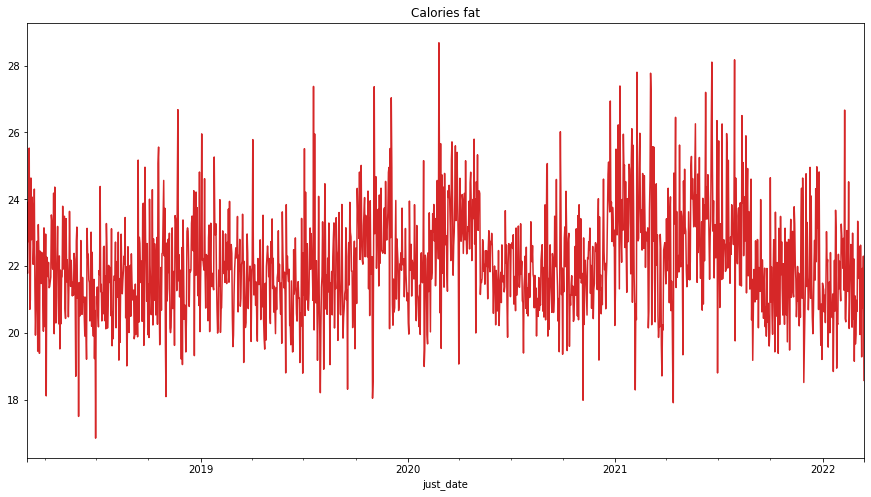

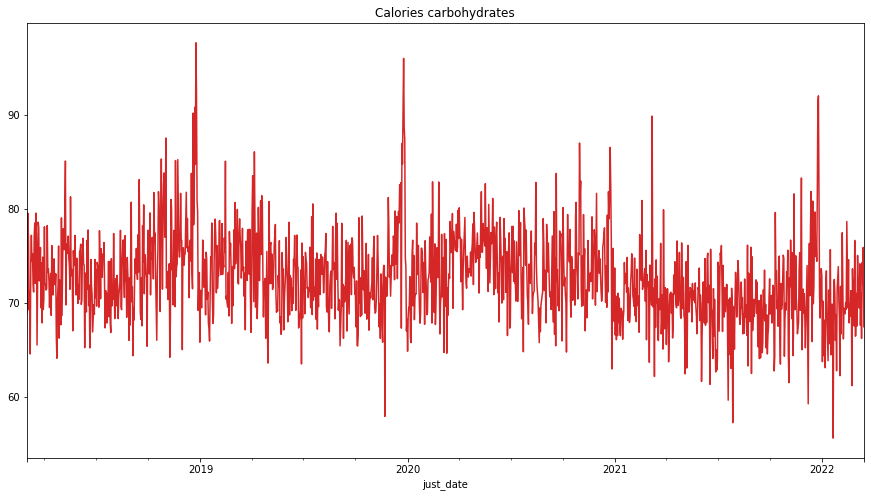

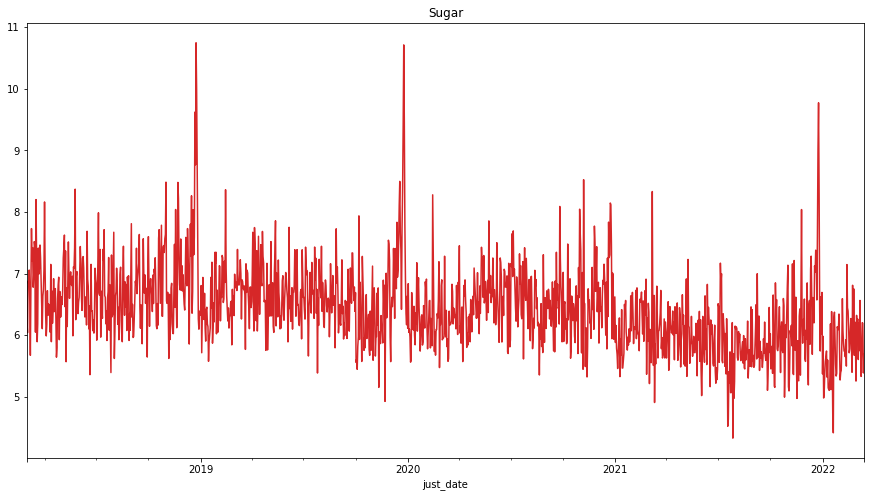

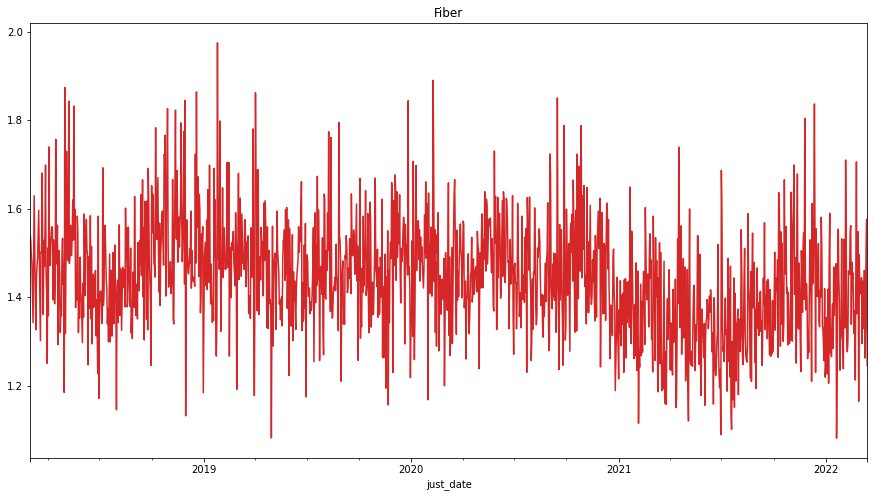

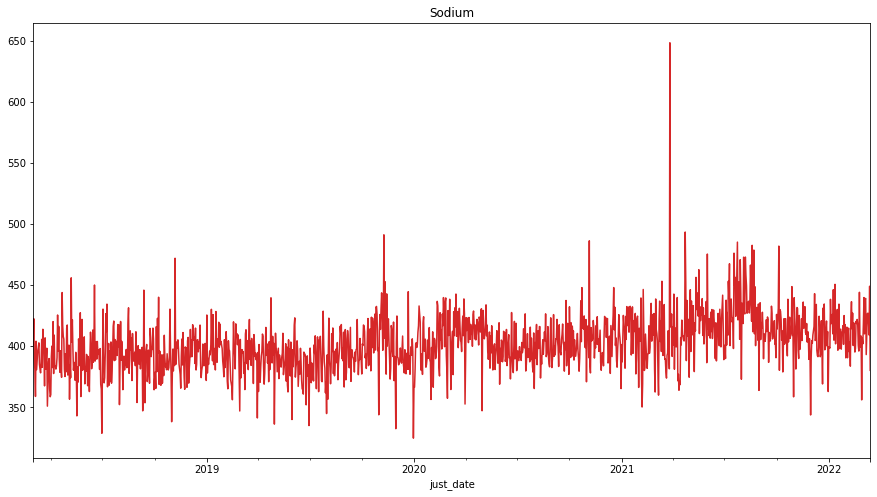

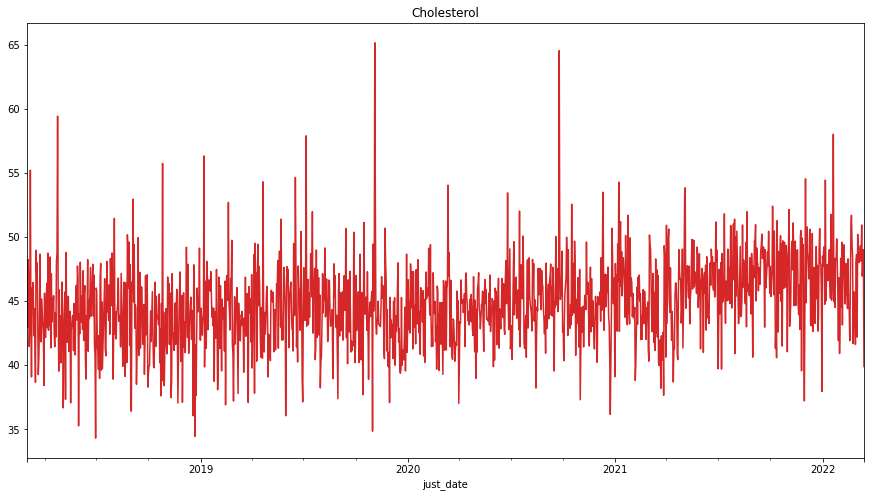

In [31]:
plot_all_nutritional_values(df_combined_2, 'D', 'tab:red')

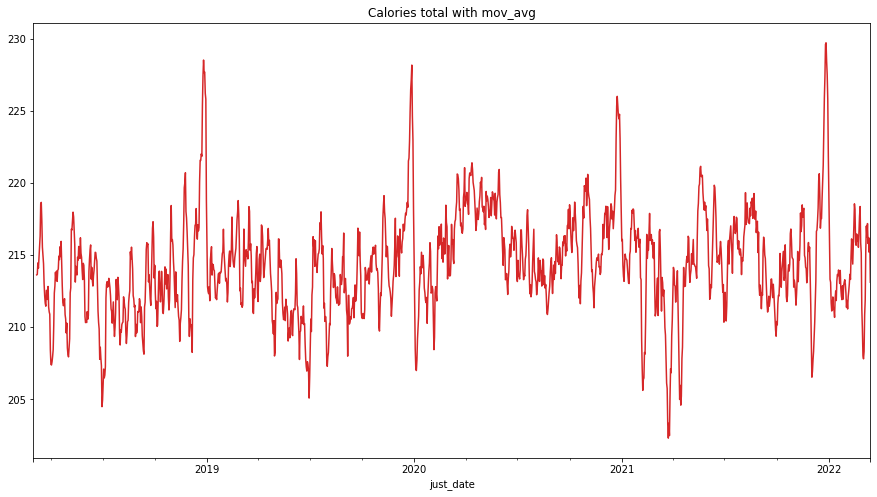

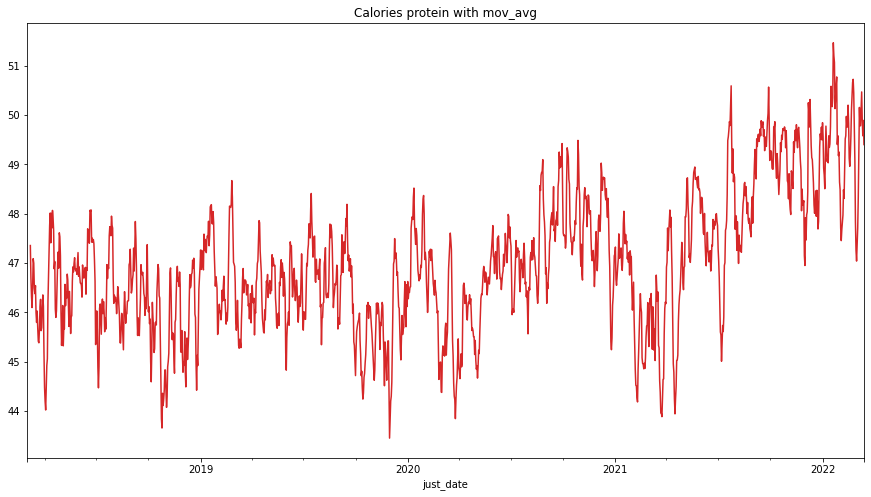

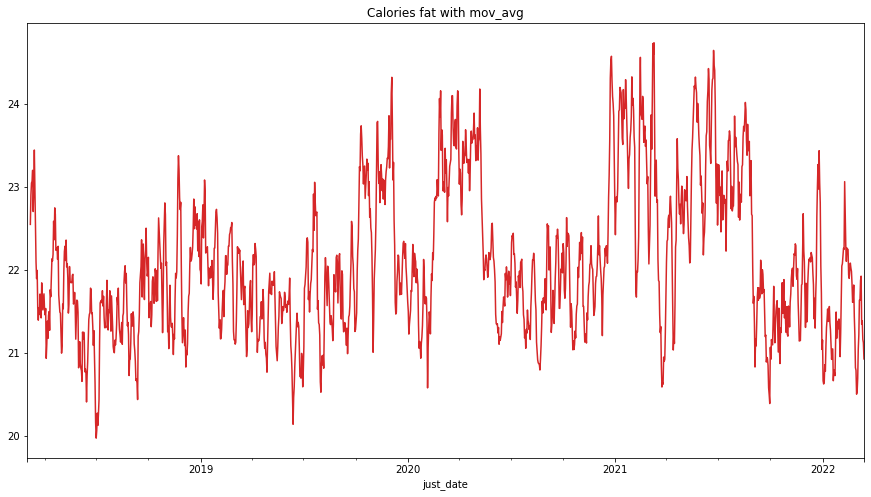

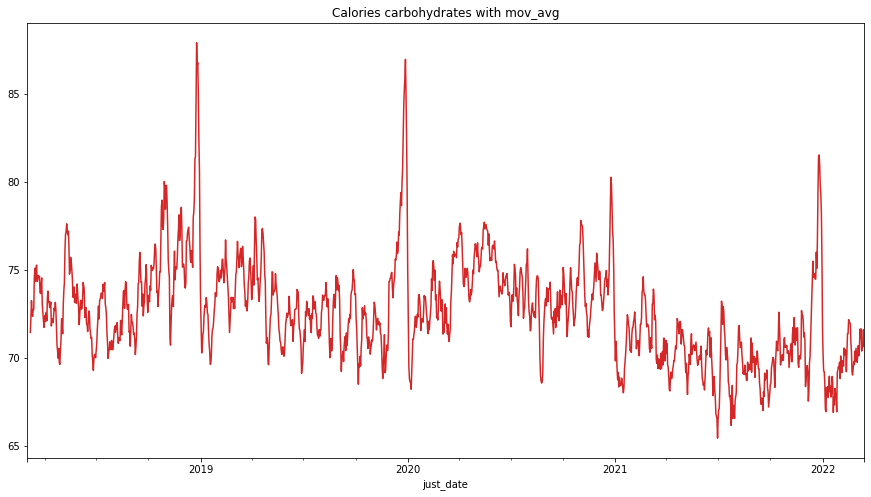

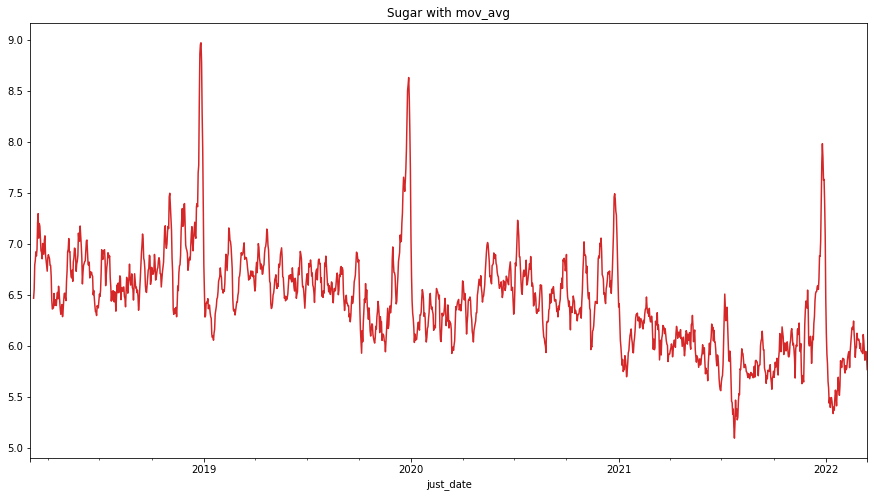

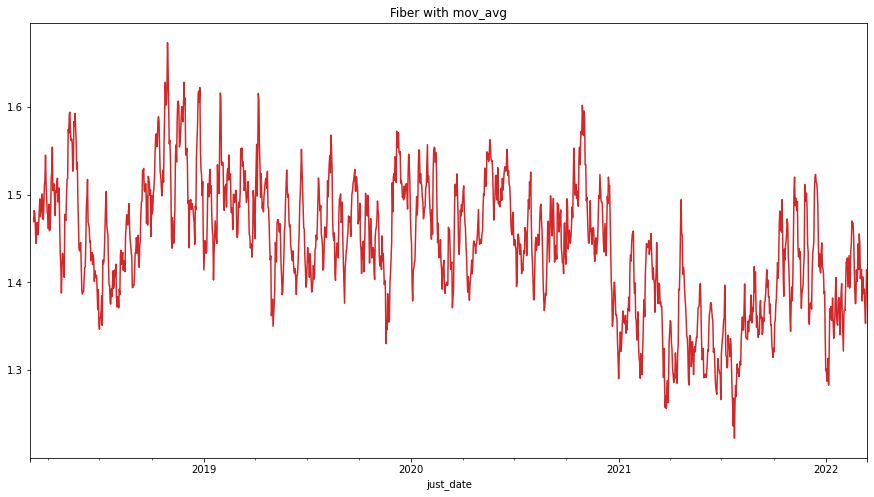

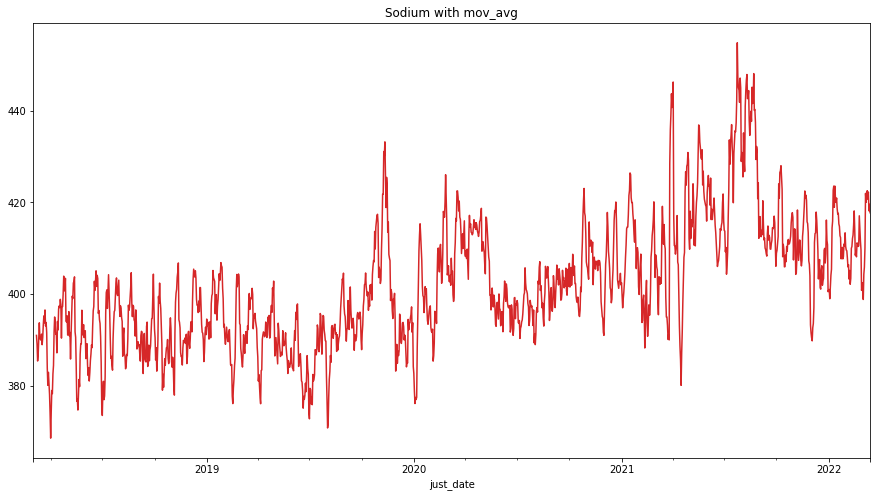

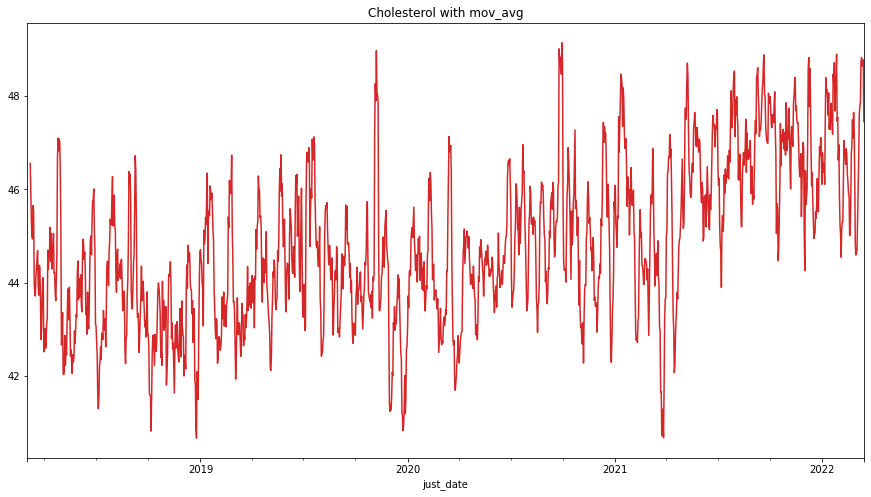

In [32]:
plot_all_nutritional_values_with_moving_average(df_combined_2, 'D', 'tab:red', 7)

### Next, we will split the dataset for each year and plot the nutritional timeseries 

### Plotting timeseries for year 2018 (Based on average daily caloric intake per 100g)

In [33]:
df_combined_2018 = df_combined_2[df_combined_2['food_post_date'] < '2019-01-01']

In [34]:
len(df_combined_2018)

94480

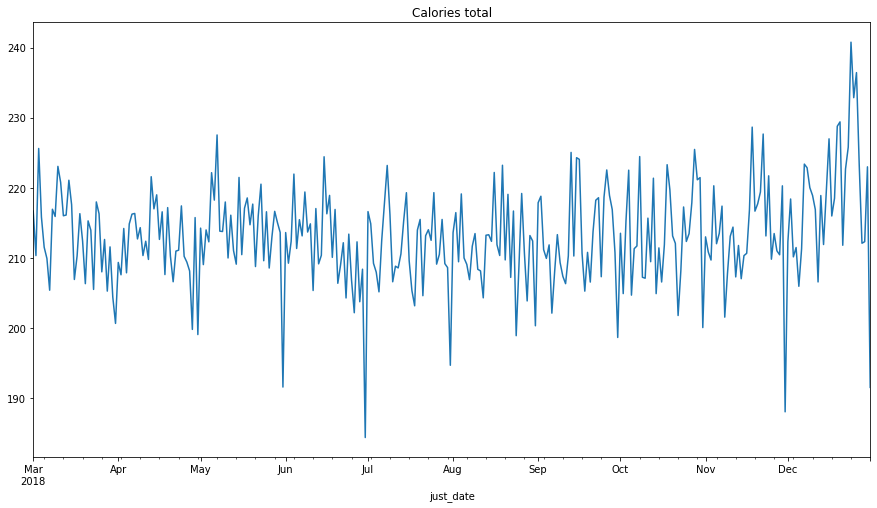

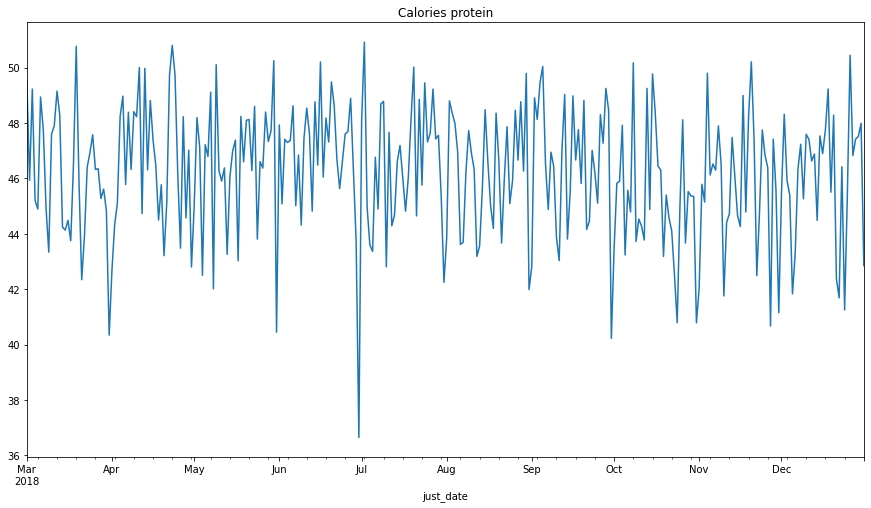

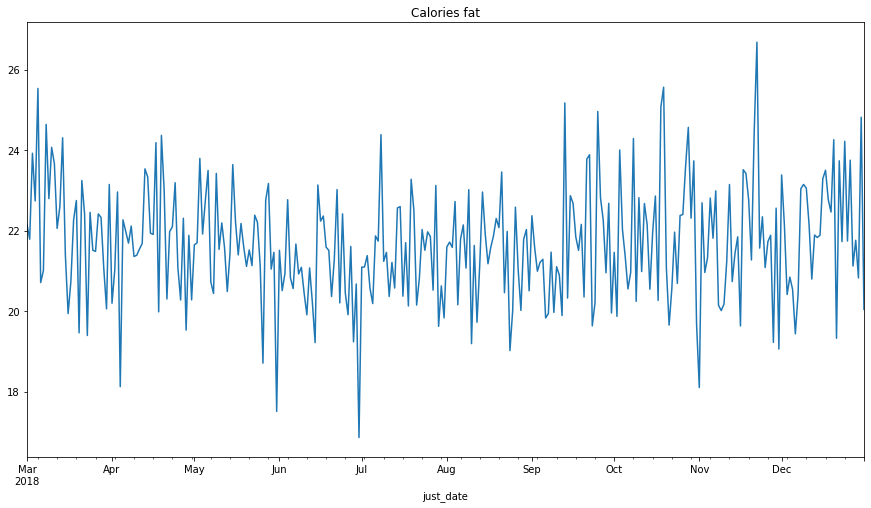

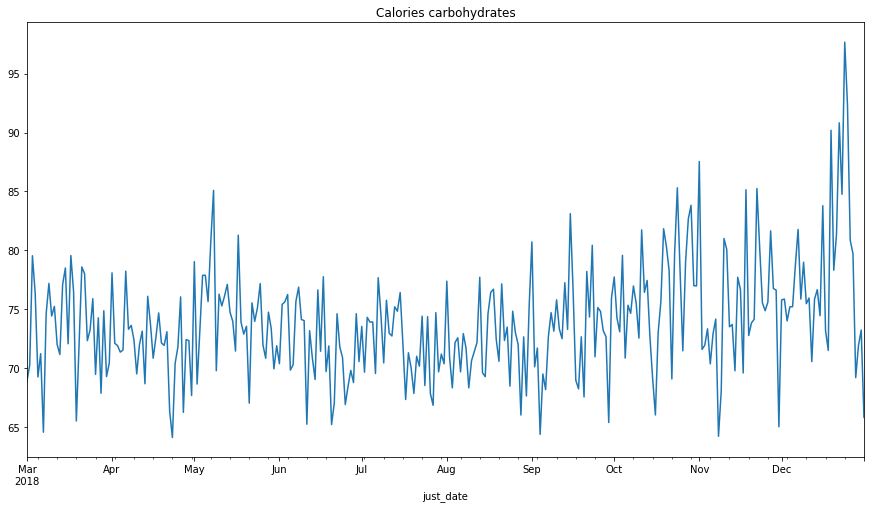

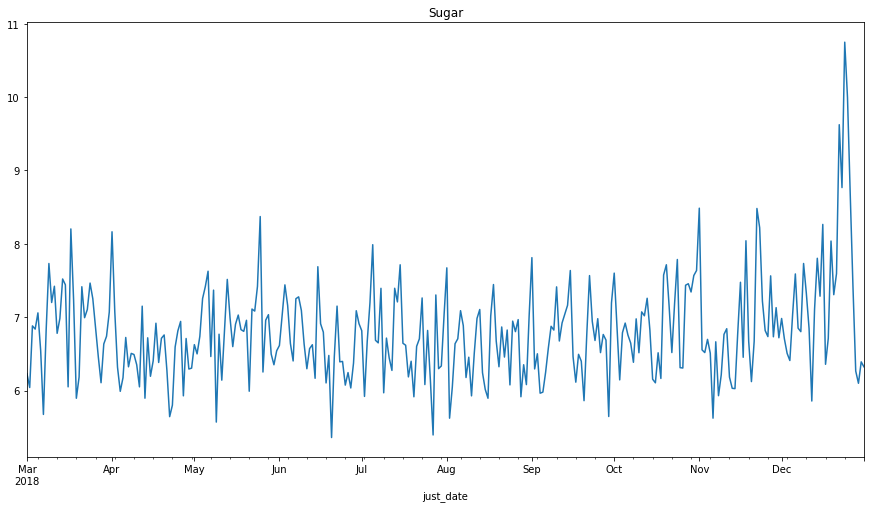

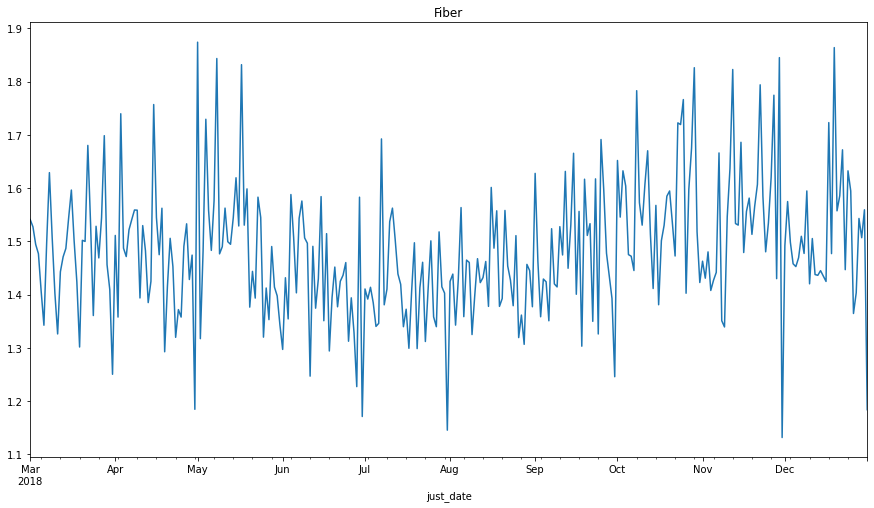

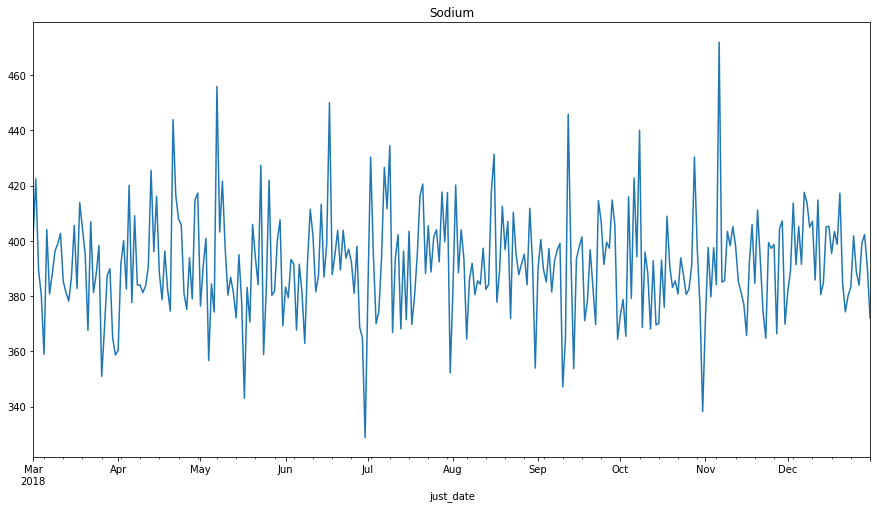

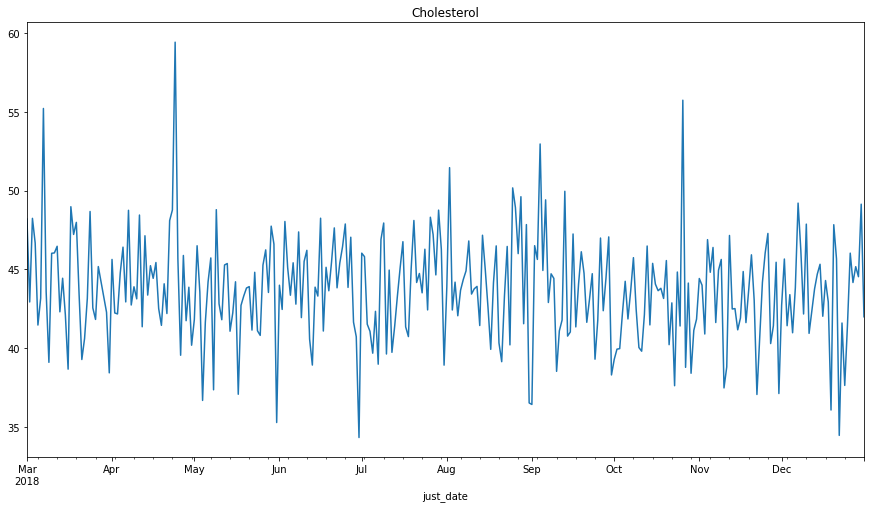

In [35]:
plot_all_nutritional_values(df_combined_2018, 'D', 'tab:blue')

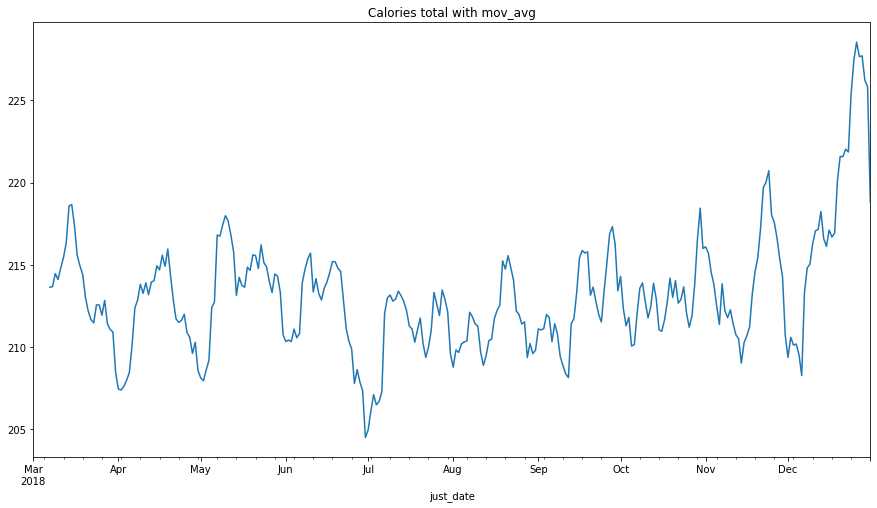

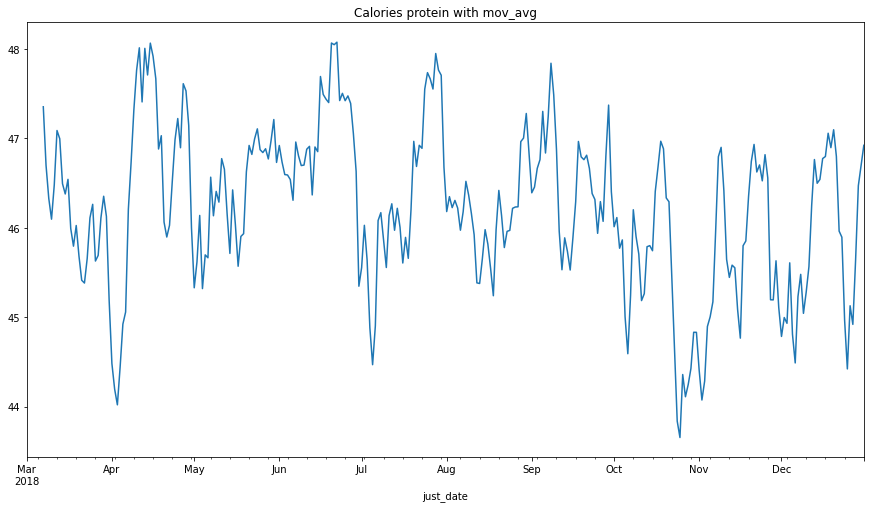

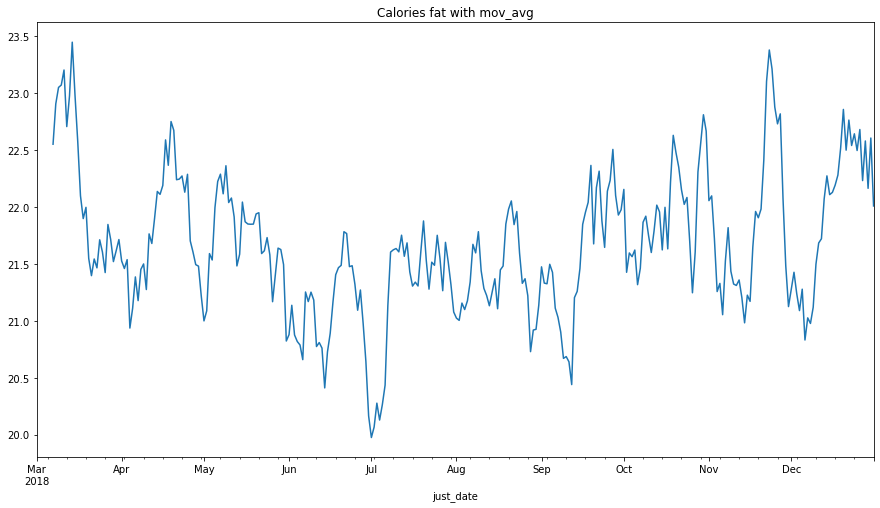

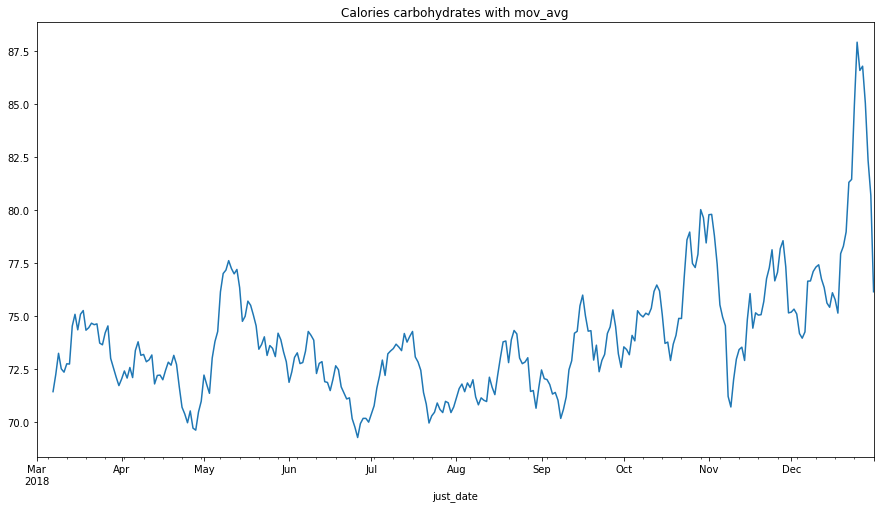

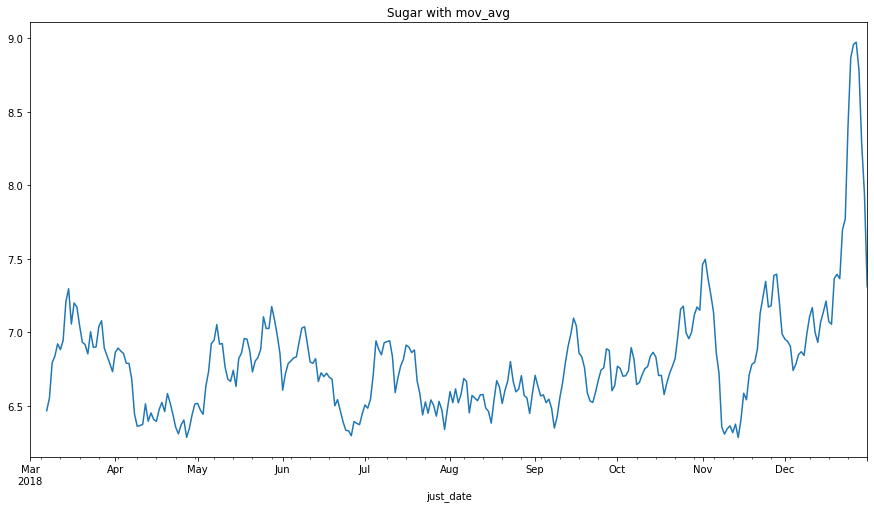

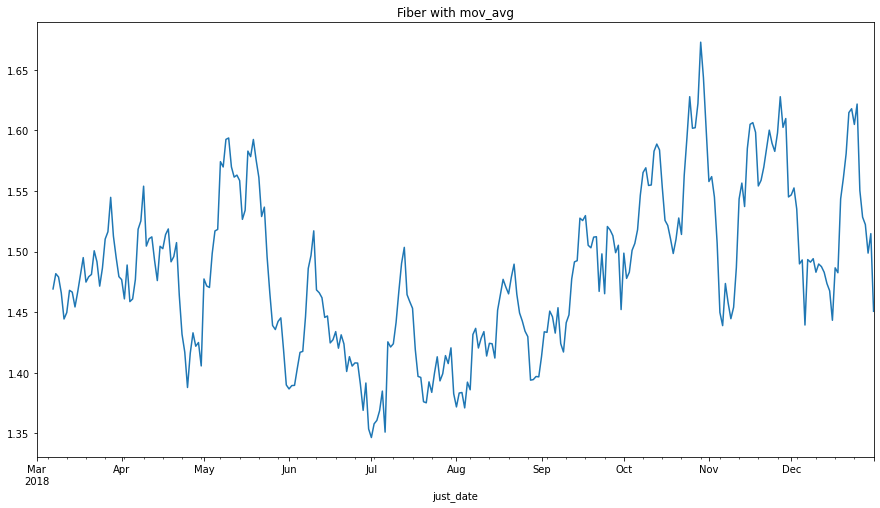

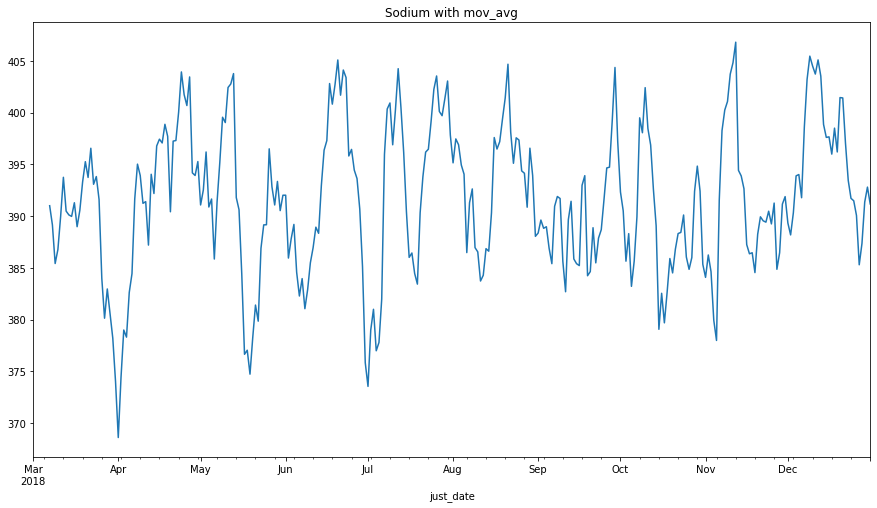

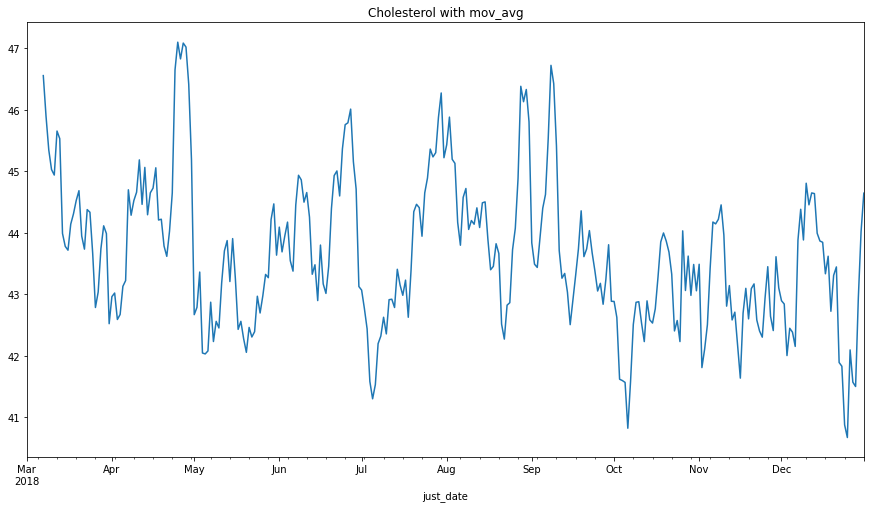

In [36]:
plot_all_nutritional_values_with_moving_average(df_combined_2018, 'D', 'tab:blue', 7)

### Plotting timeseries for year 2019 (Based on average daily caloric intake per 100g)

In [37]:
df_combined_2018_1 = df_combined_2[df_combined_2['food_post_date'] >= '2019-01-01']

In [38]:
df_combined_2019 = df_combined_2018_1[df_combined_2018_1['food_post_date'] < '2020-01-01']

In [39]:
len(df_combined_2019)

128665

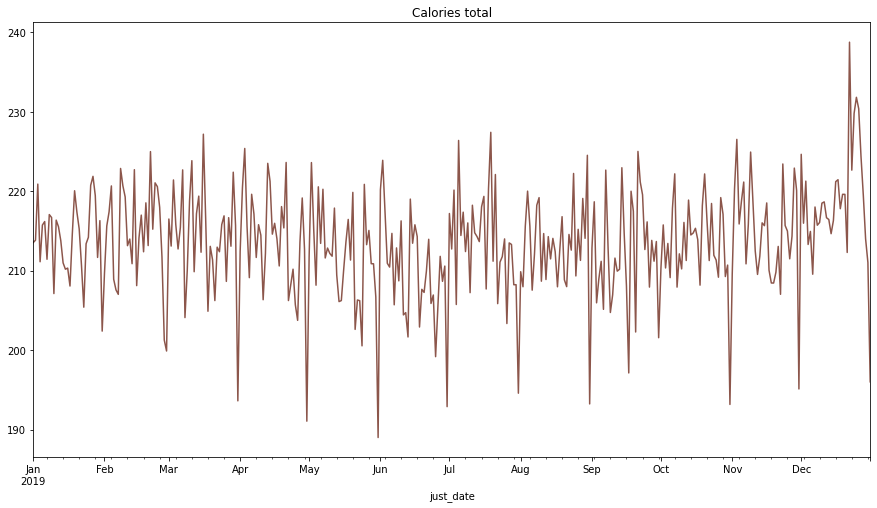

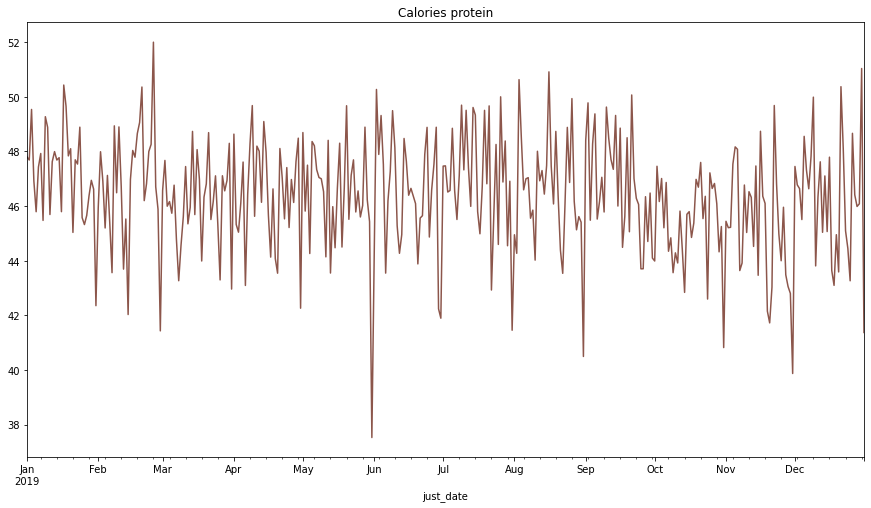

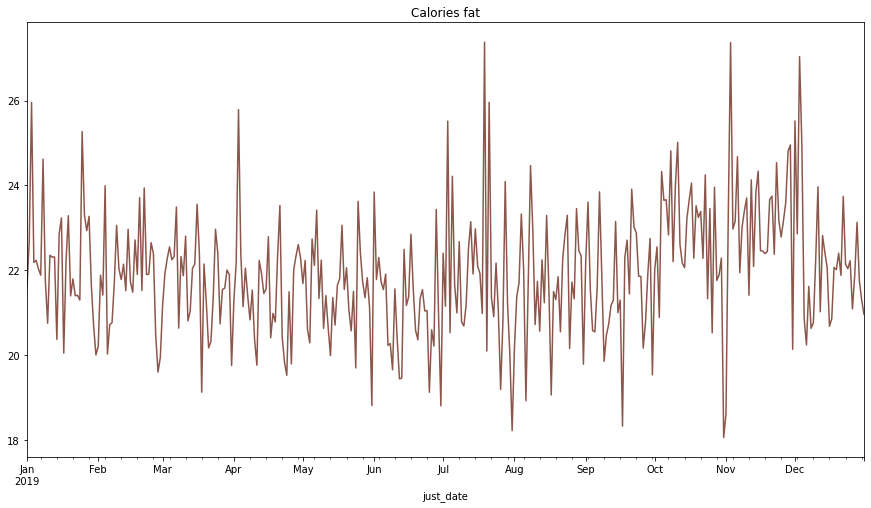

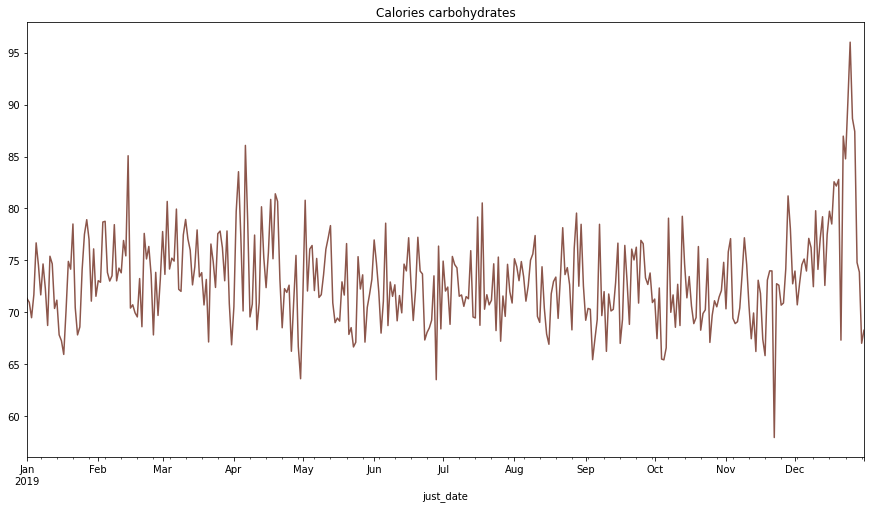

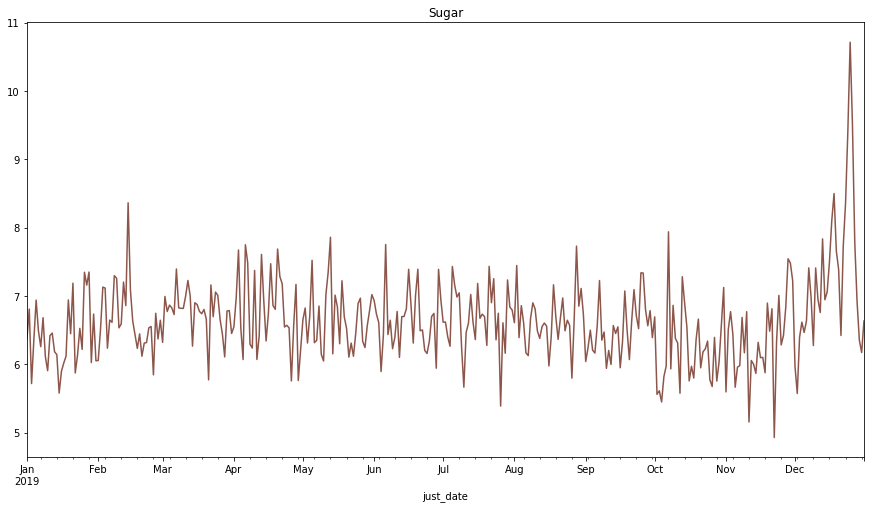

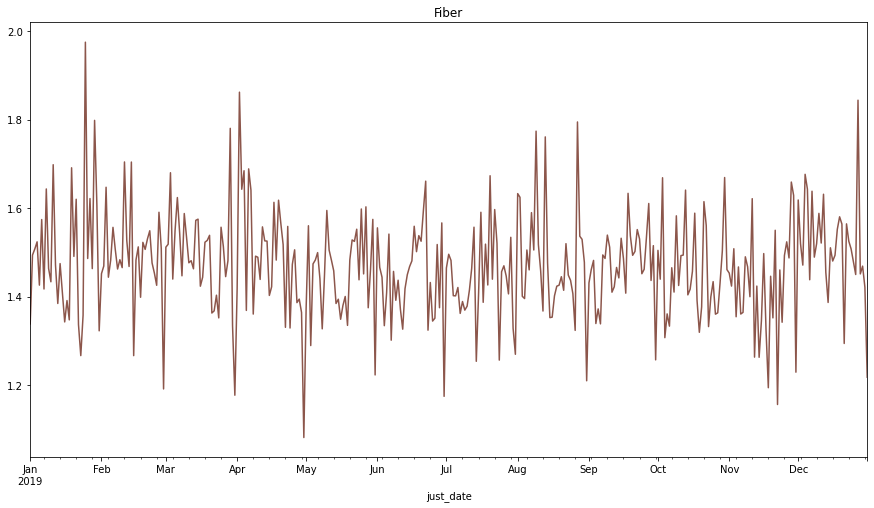

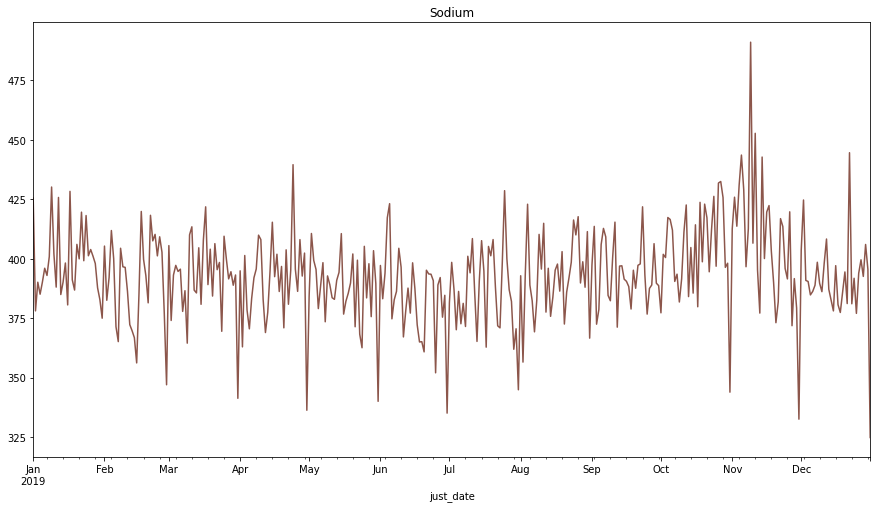

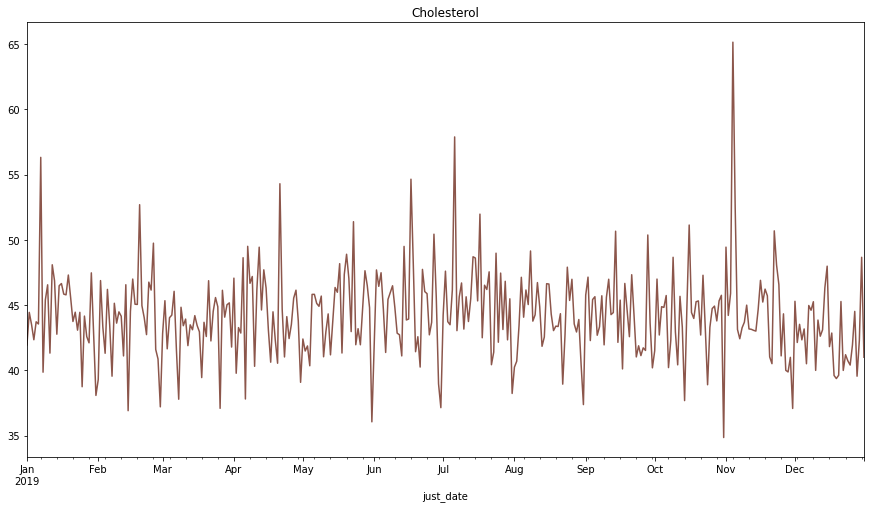

In [40]:
plot_all_nutritional_values(df_combined_2019, 'D', 'tab:brown')

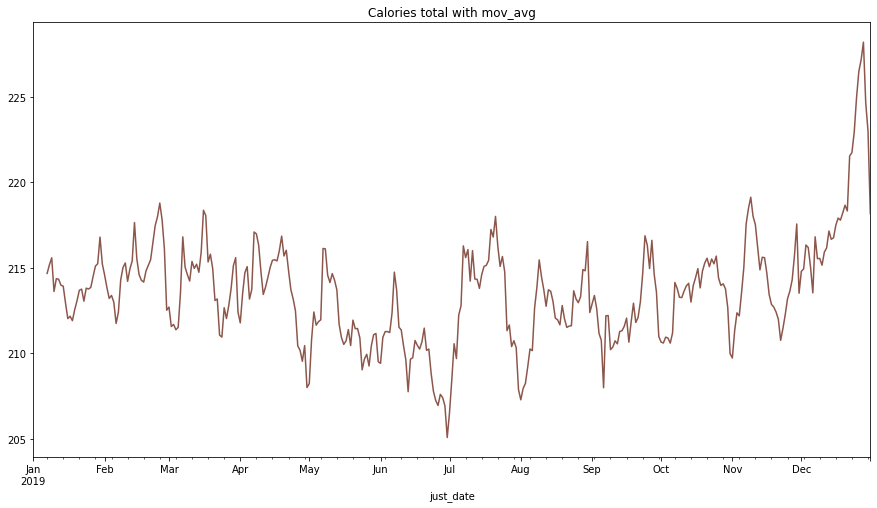

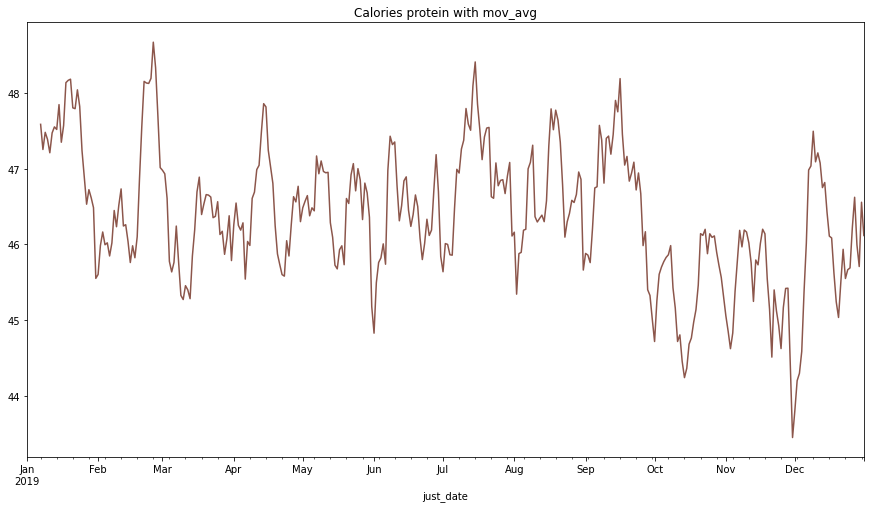

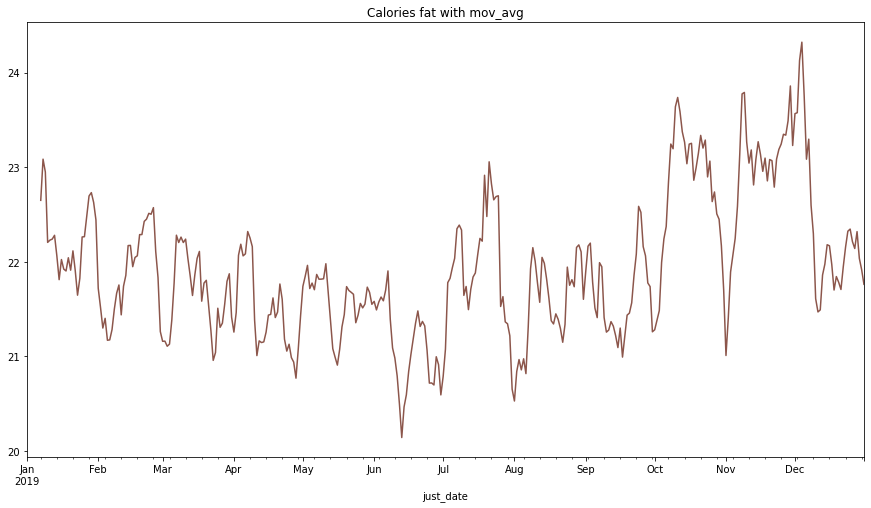

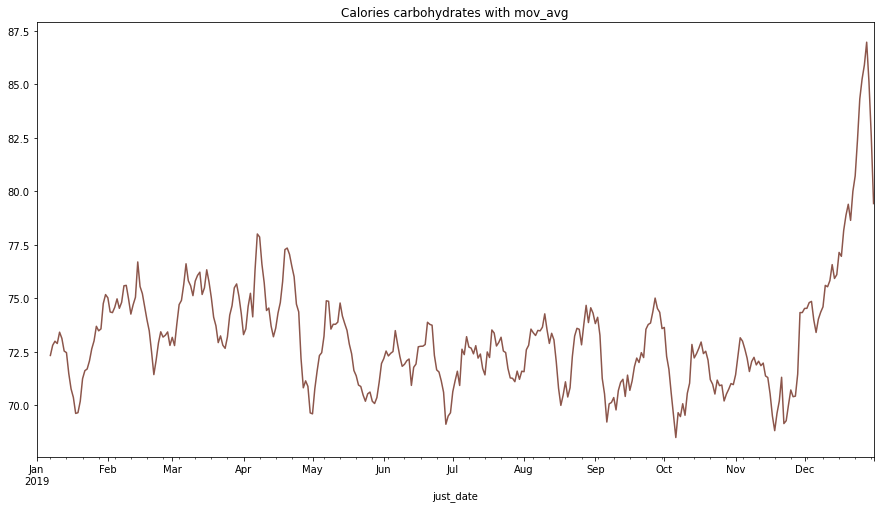

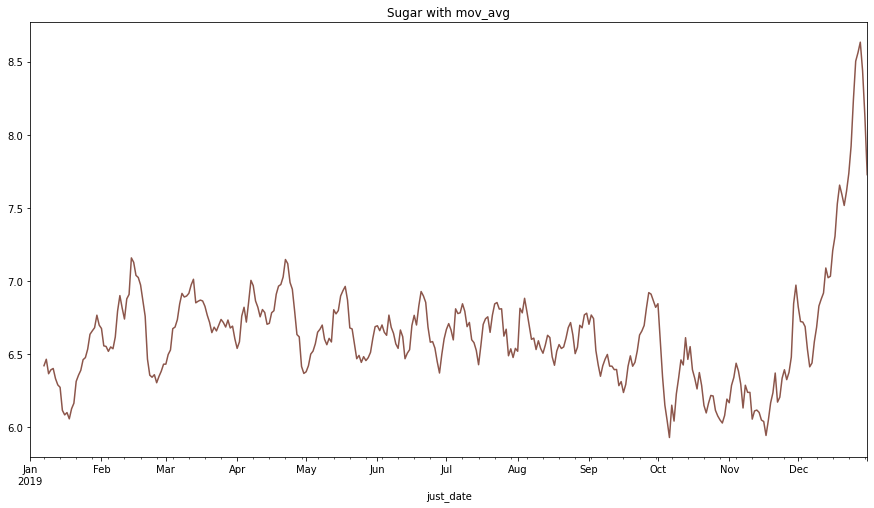

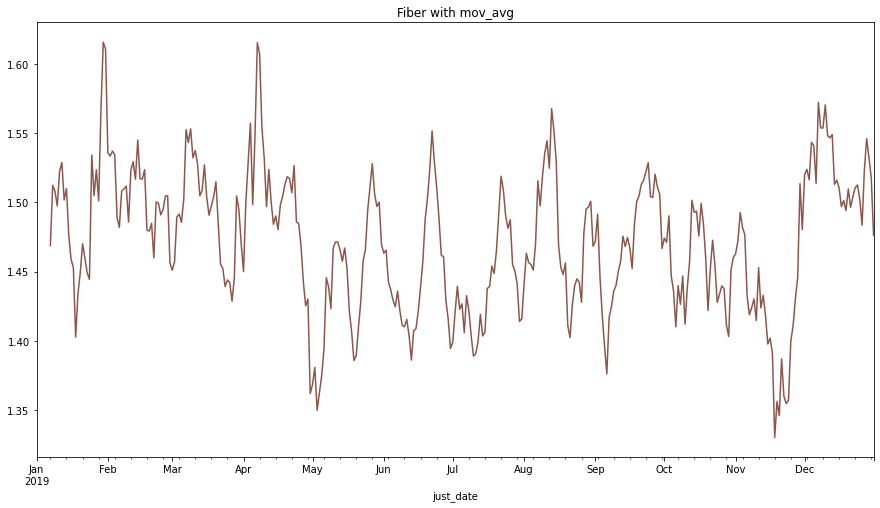

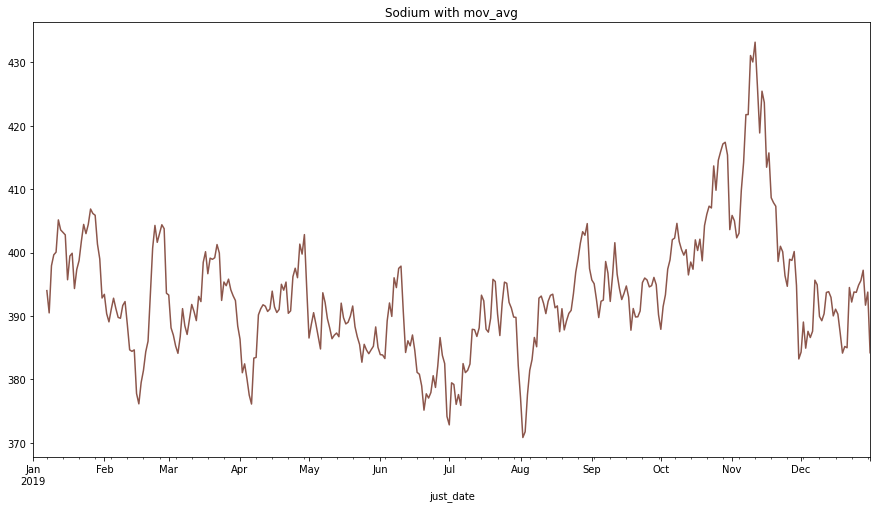

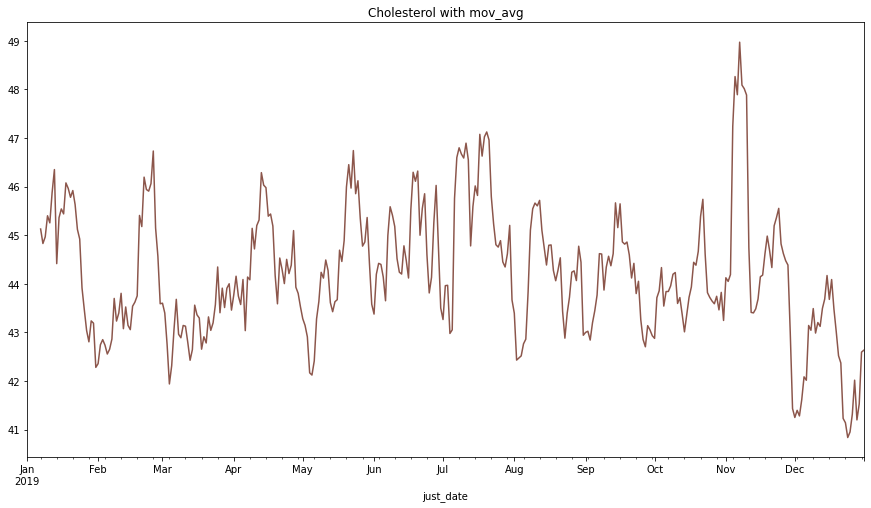

In [41]:
plot_all_nutritional_values_with_moving_average(df_combined_2019, 'D', 'tab:brown', 7)

### Plotting timeseries for year 2020 (Based on average daily caloric intake per 100g)

In [42]:
df_combined_2019_1 = df_combined_2[df_combined_2['food_post_date'] >= '2020-01-01']

In [43]:
df_combined_2020 = df_combined_2019_1[df_combined_2019_1['food_post_date'] < '2021-01-01']

In [44]:
len(df_combined_2020)

168582

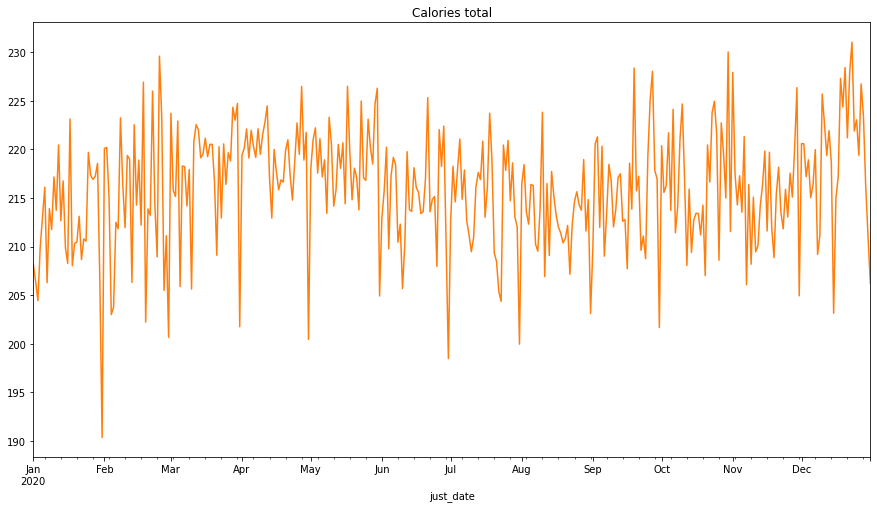

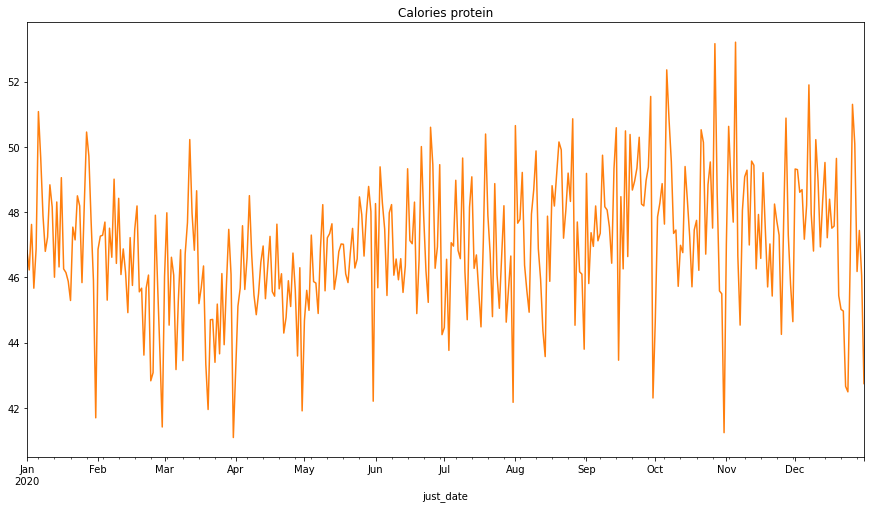

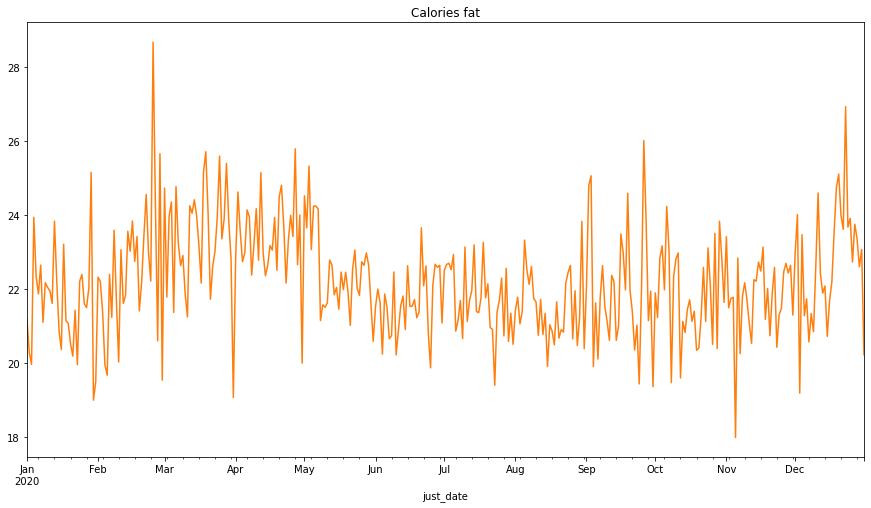

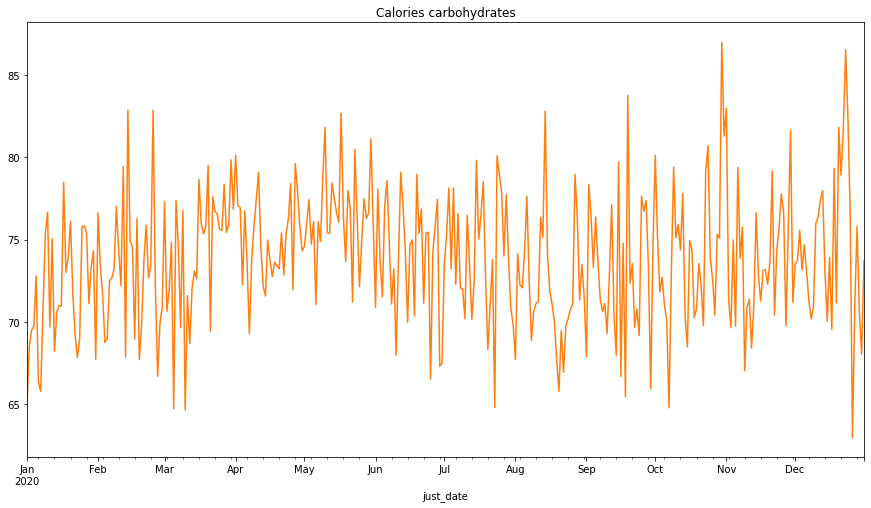

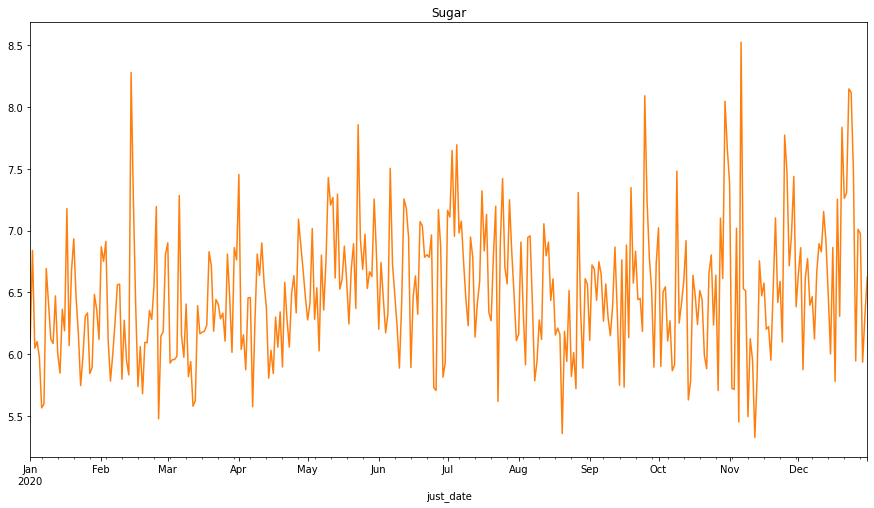

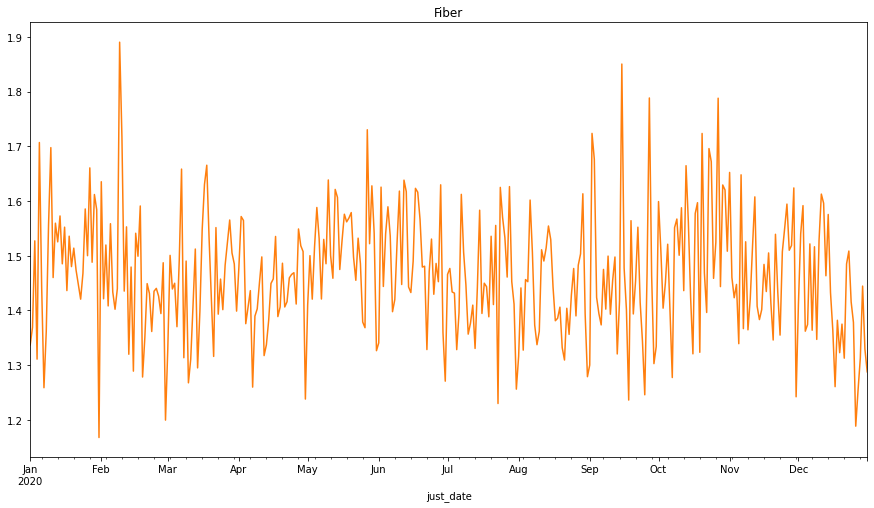

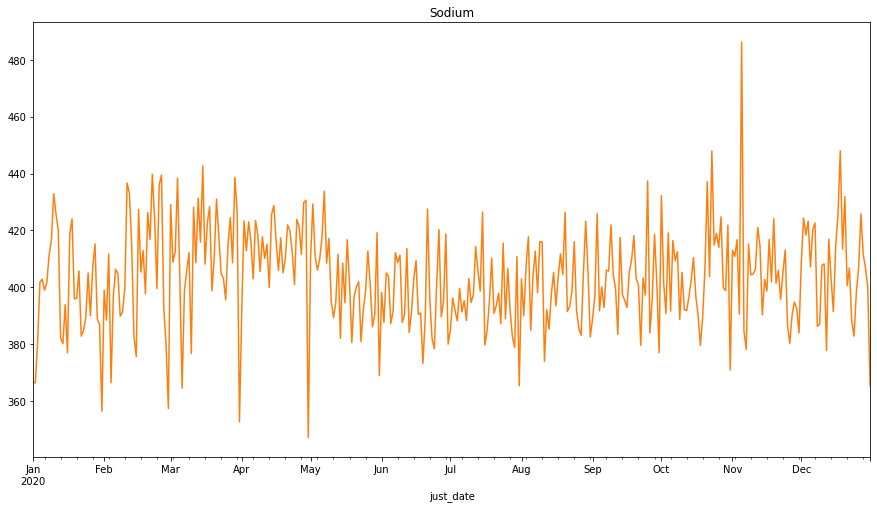

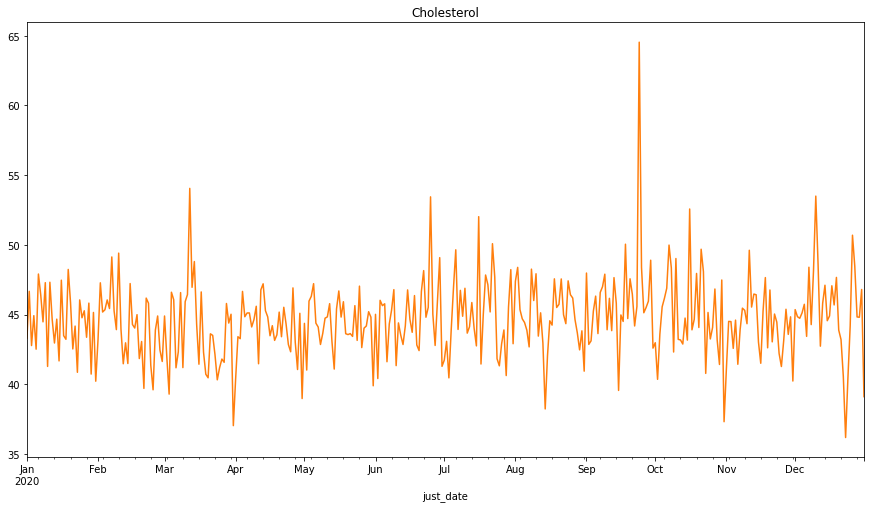

In [45]:
plot_all_nutritional_values(df_combined_2020, 'D', 'tab:orange')

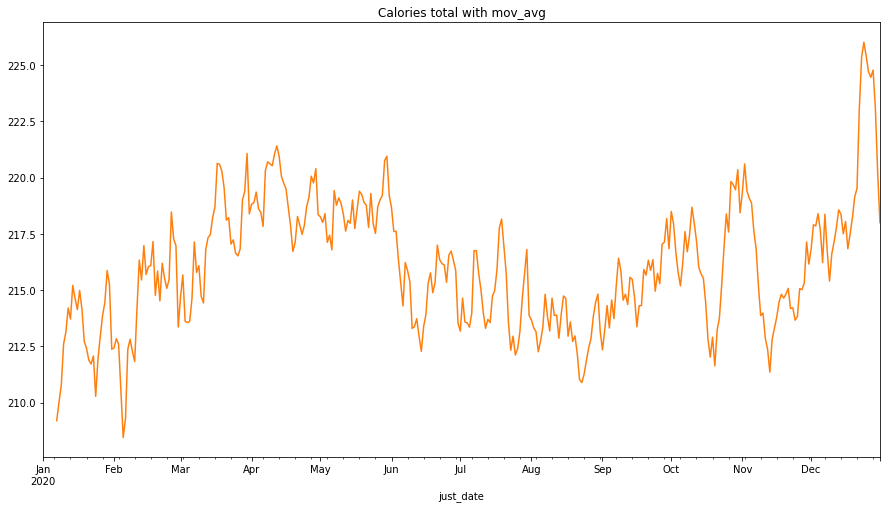

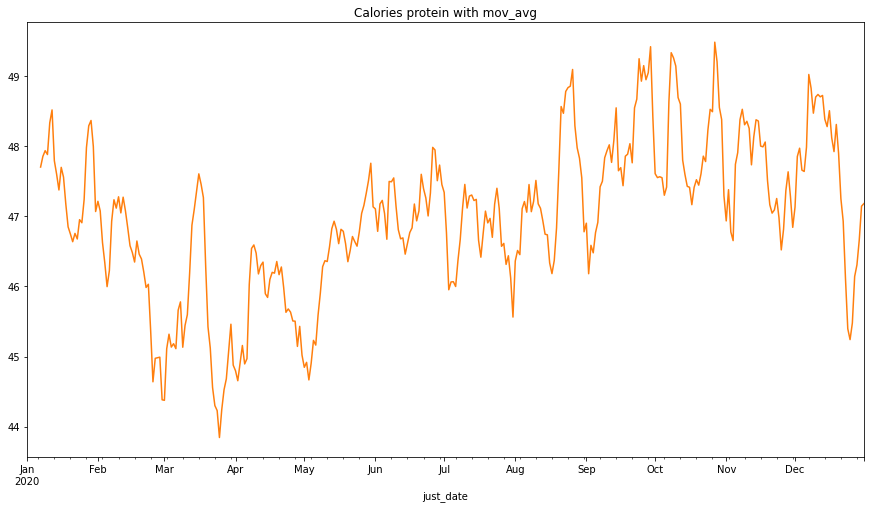

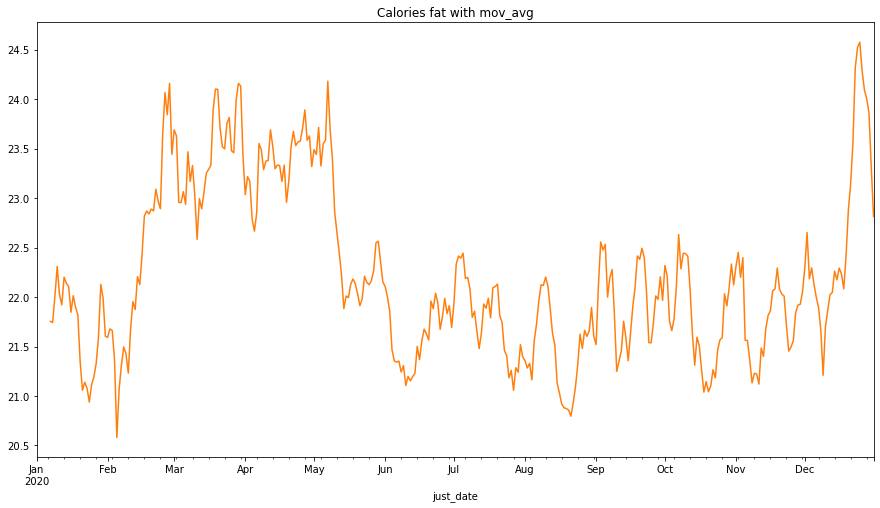

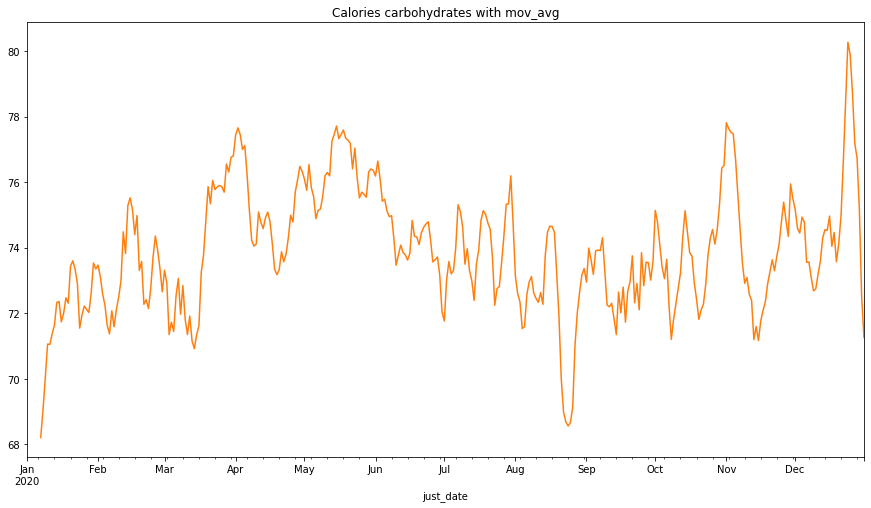

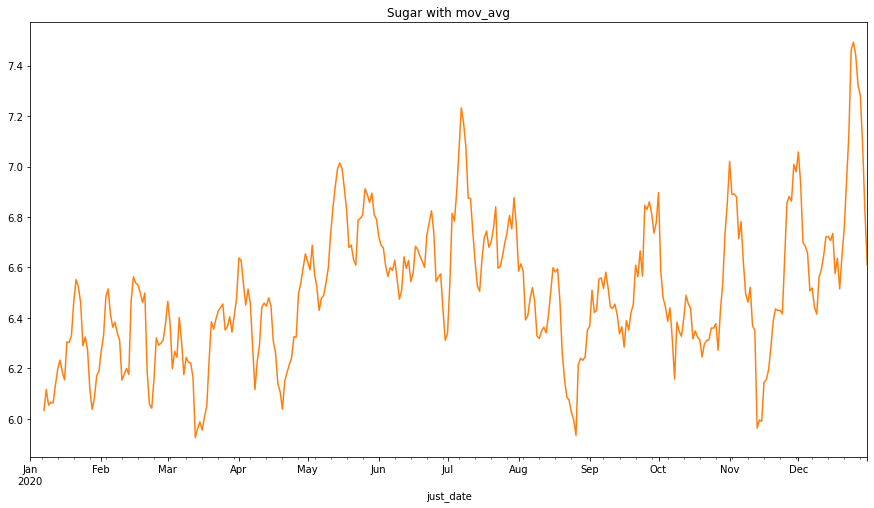

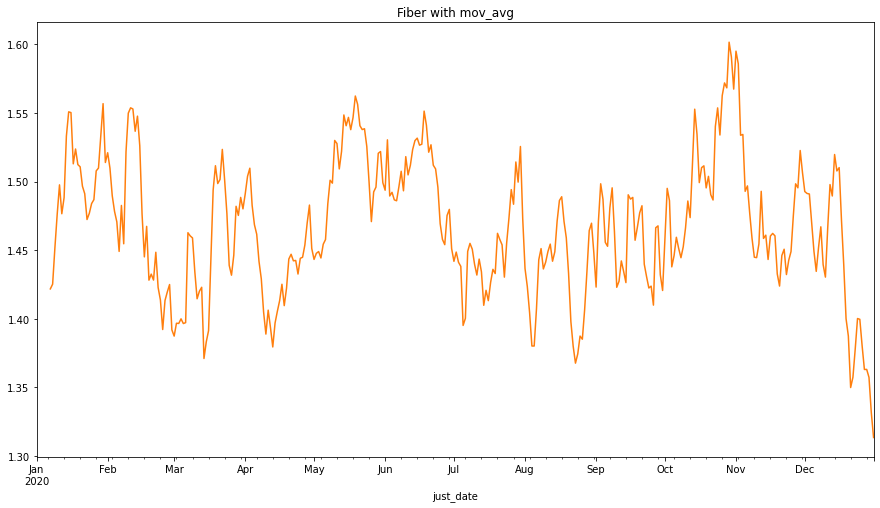

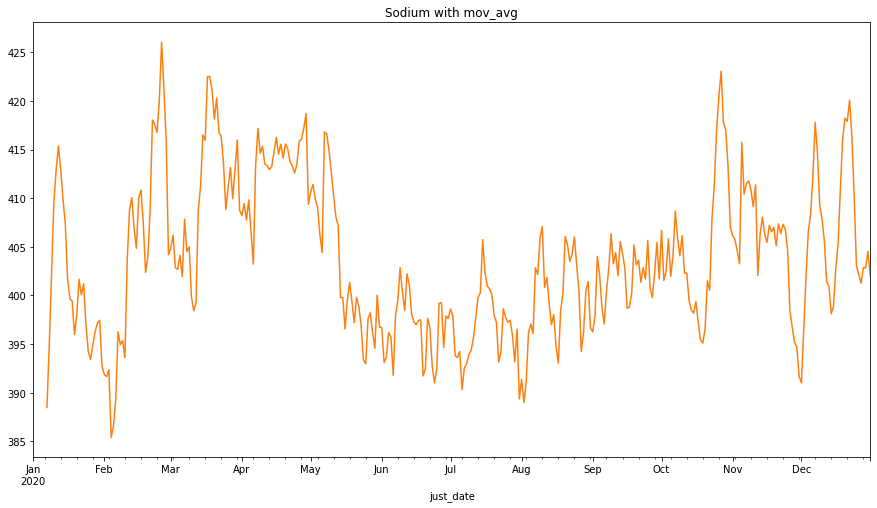

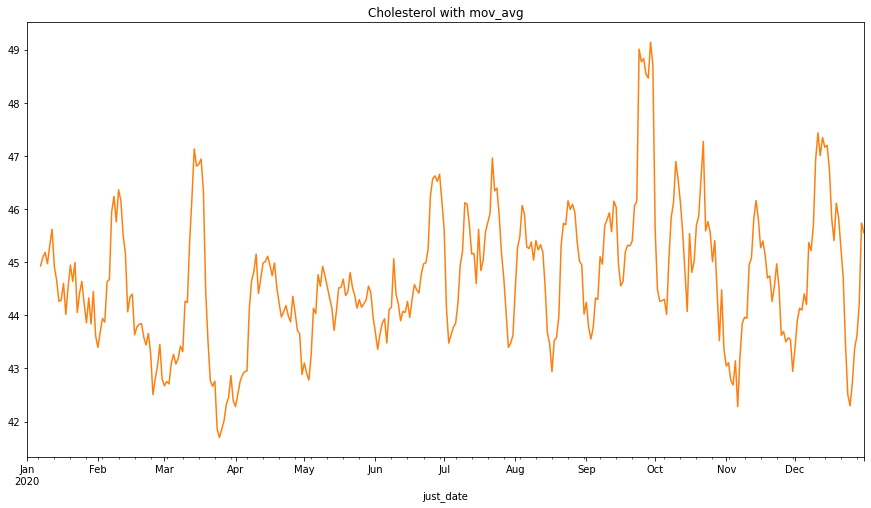

In [46]:
plot_all_nutritional_values_with_moving_average(df_combined_2020, 'D', 'tab:orange', 7)

### Plotting timeseries for year 2021 (Based on average daily caloric intake per 100g)

In [47]:
df_combined_2020_1 = df_combined_2[df_combined_2['food_post_date'] >= '2021-01-01']

In [48]:
df_combined_2021 = df_combined_2020_1[df_combined_2020_1['food_post_date'] < '2022-01-01']

In [49]:
len(df_combined_2021)

133344

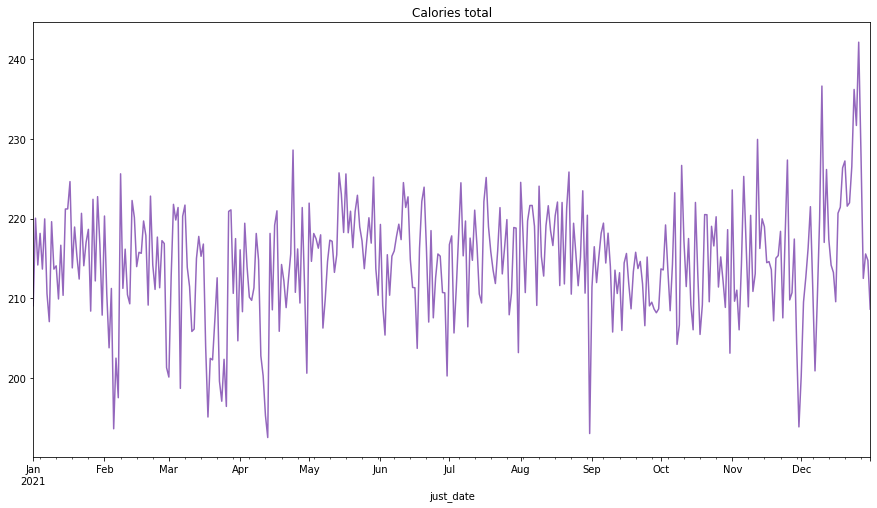

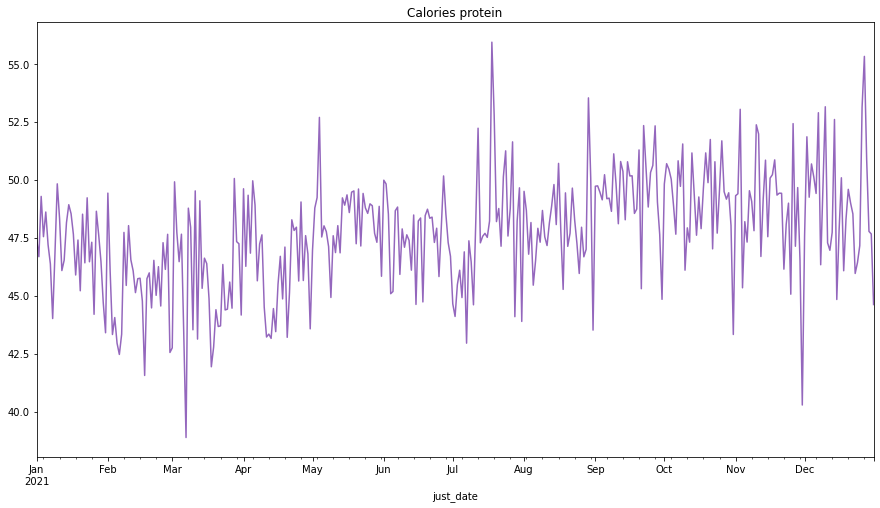

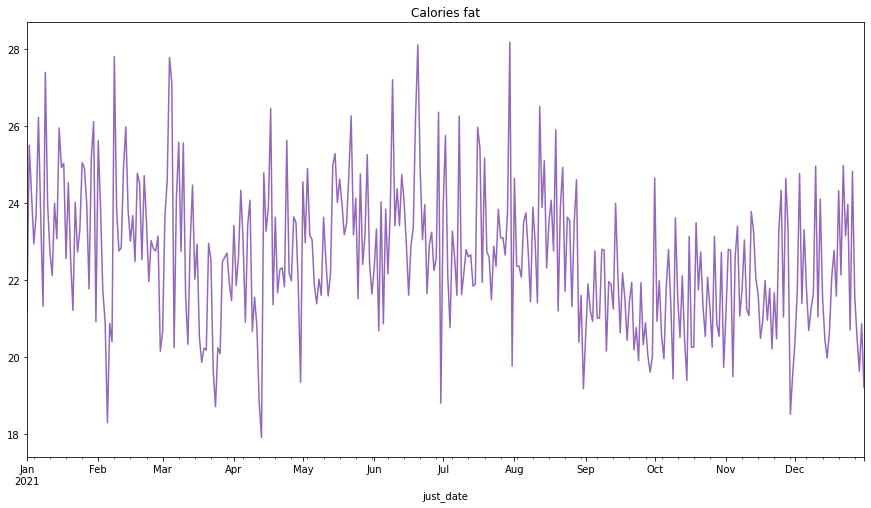

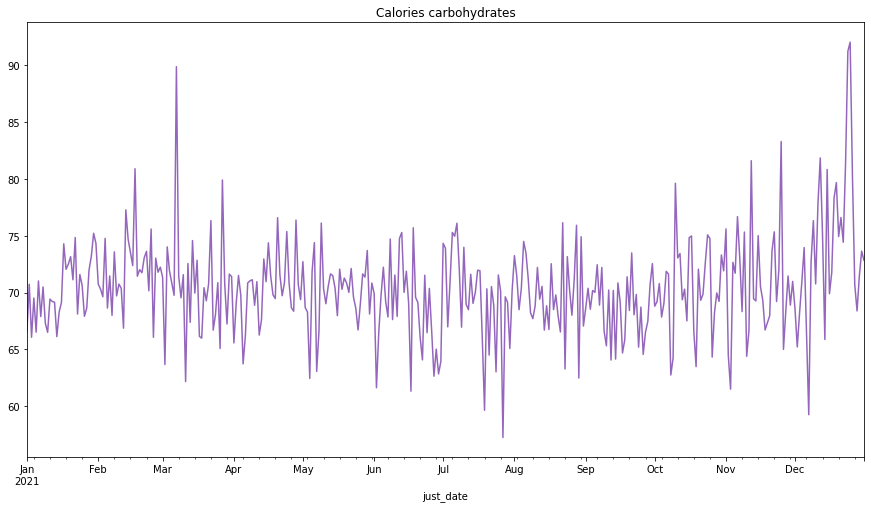

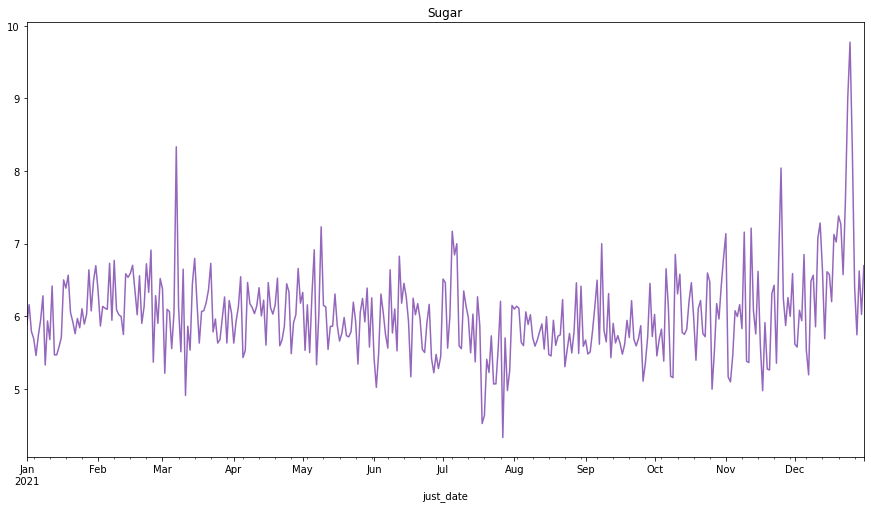

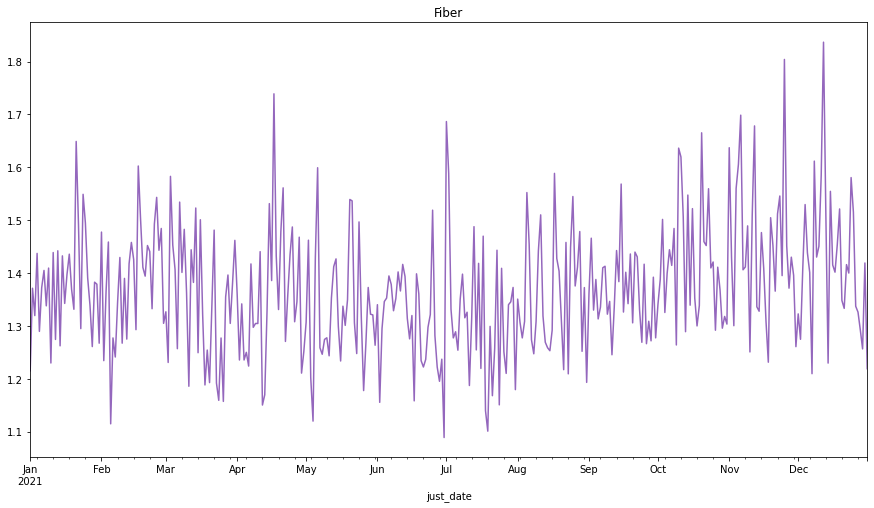

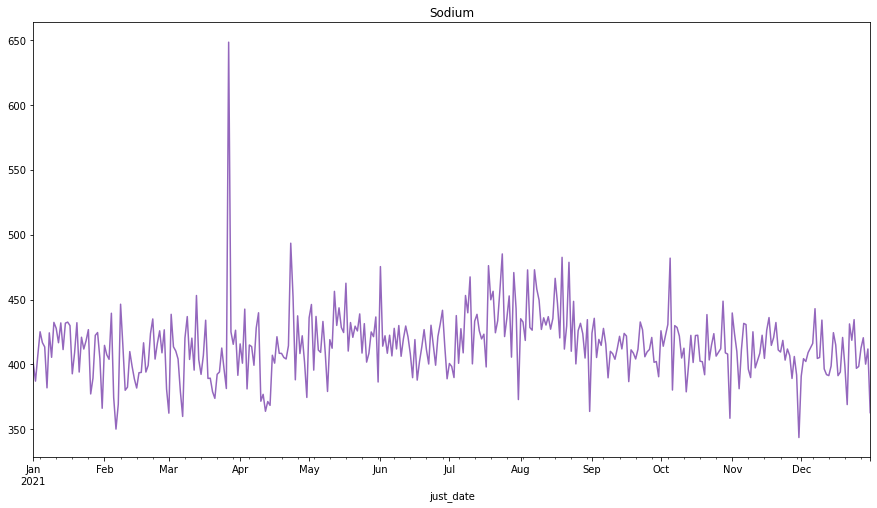

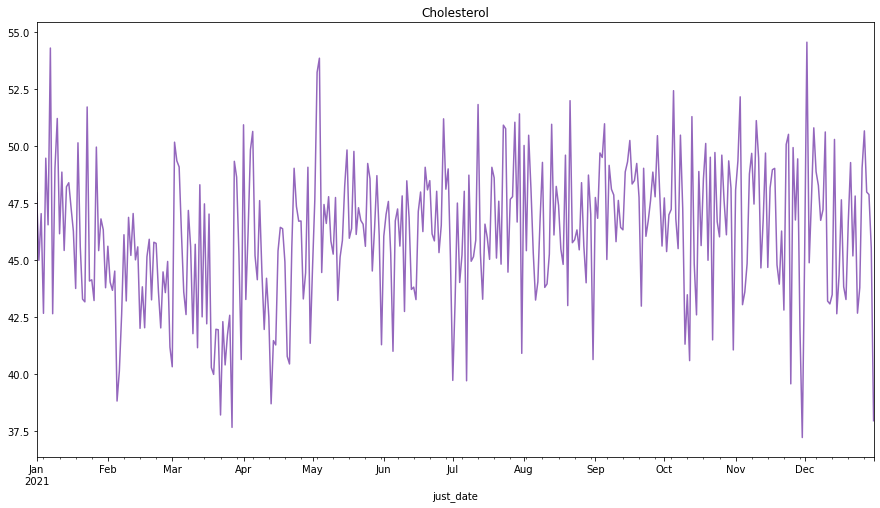

In [50]:
plot_all_nutritional_values(df_combined_2021, 'D', 'tab:purple')

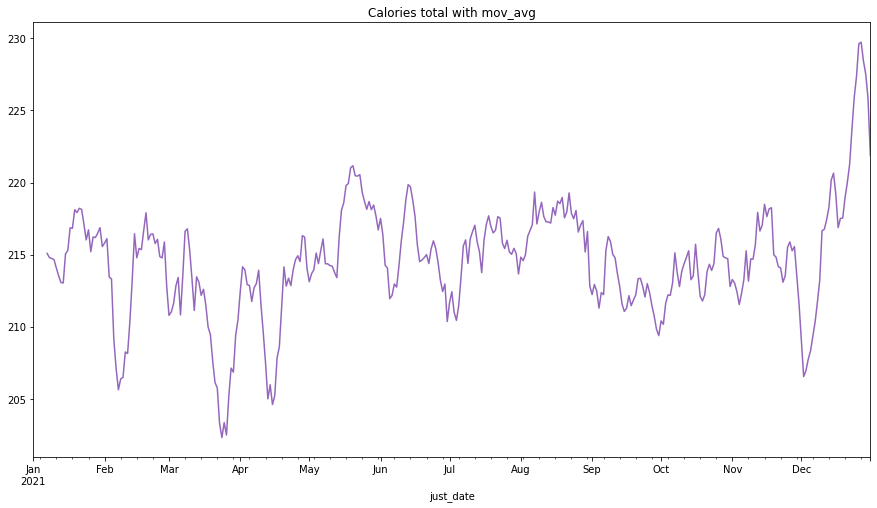

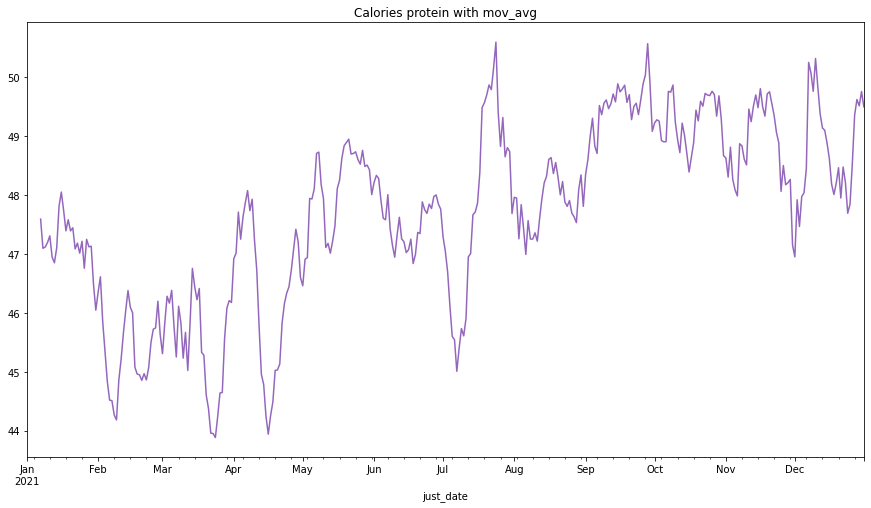

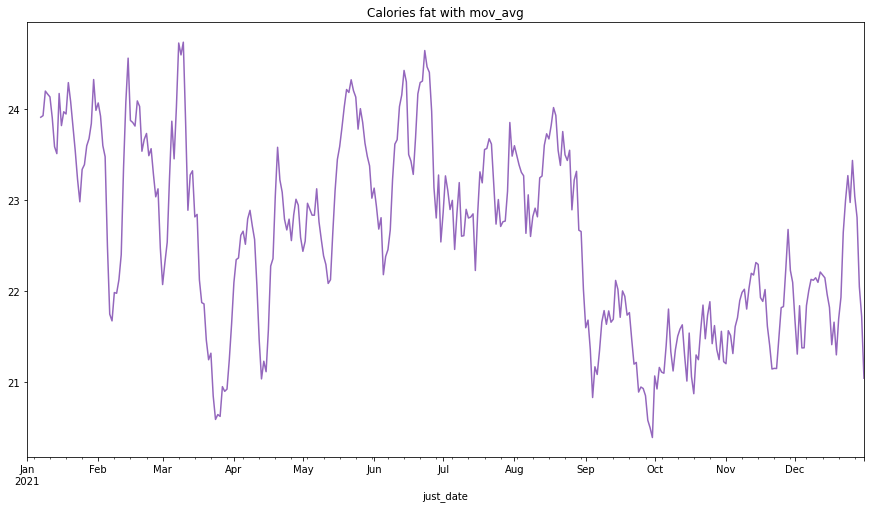

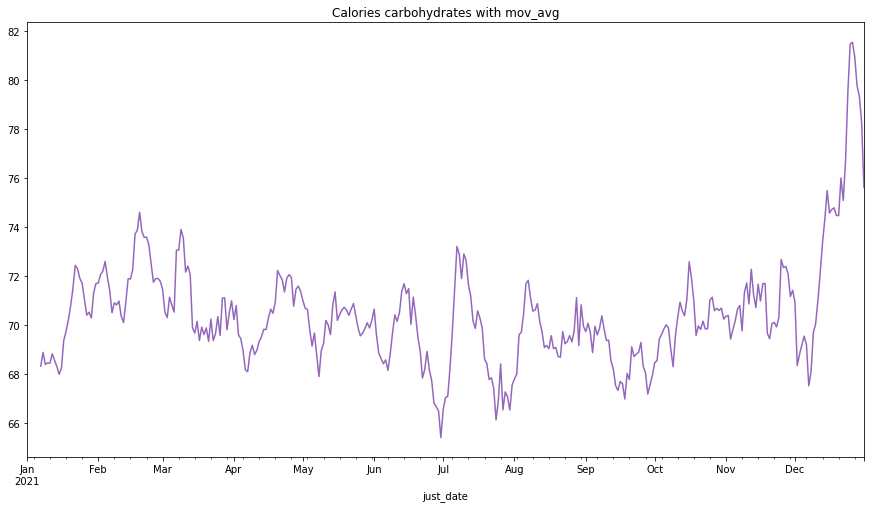

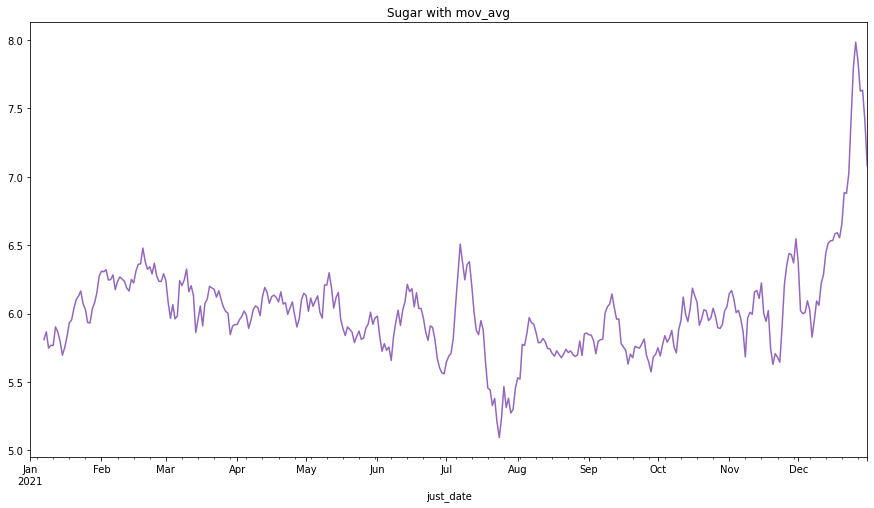

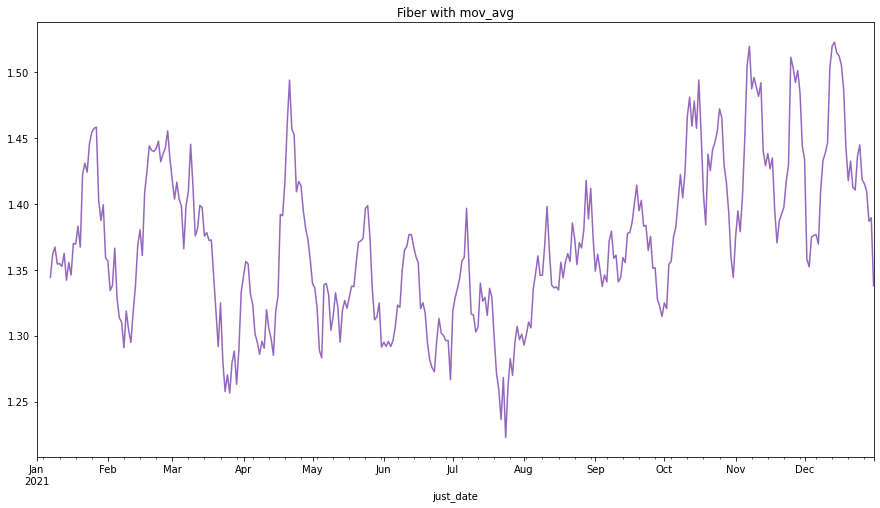

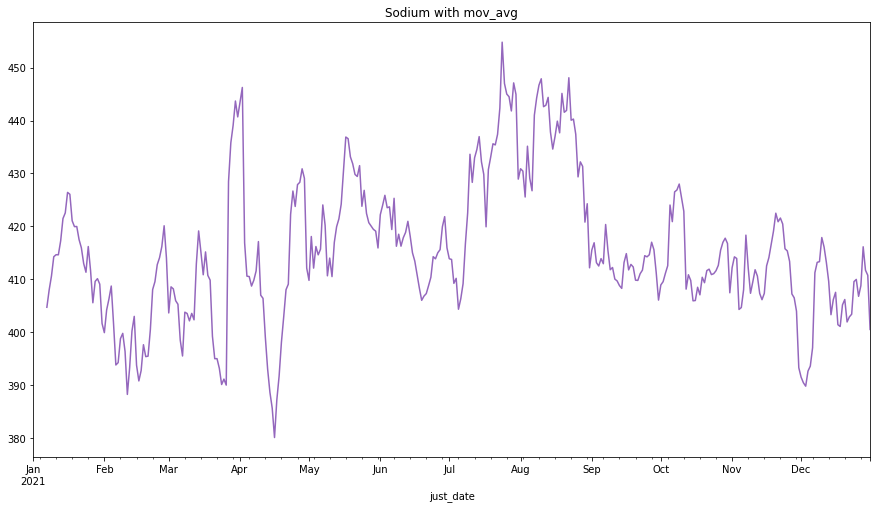

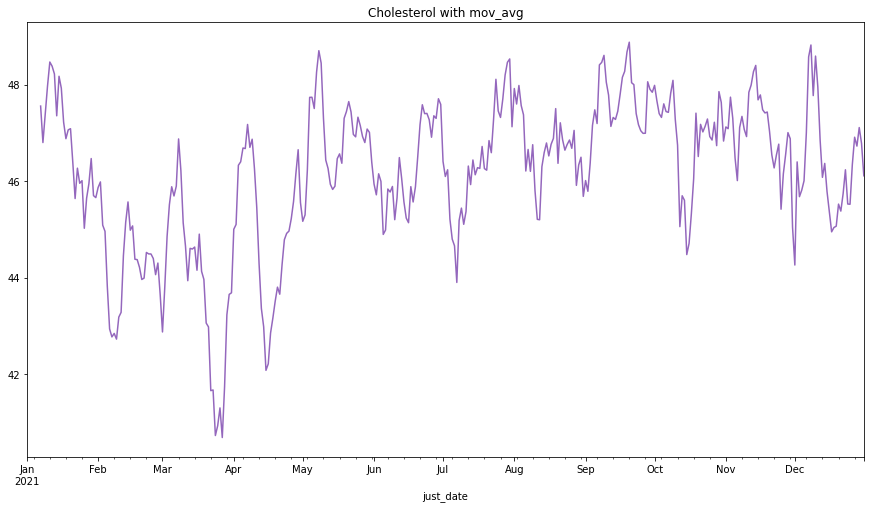

In [51]:
plot_all_nutritional_values_with_moving_average(df_combined_2021, 'D', 'tab:purple', 7)

### Plotting timeseries for year 2022 (Based on average daily caloric intake per 100g)

In [52]:
df_combined_2022 = df_combined_2[df_combined_2['food_post_date'] >= '2022-01-01']

In [53]:
len(df_combined_2022)

21394

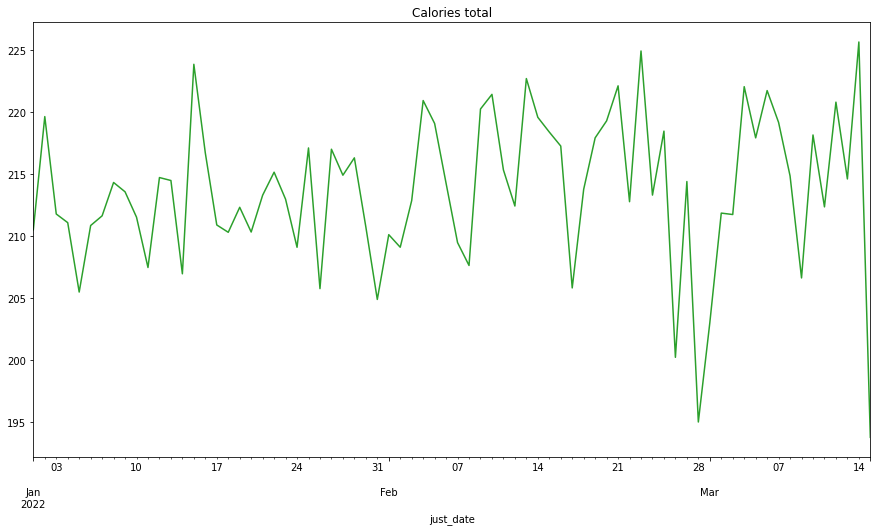

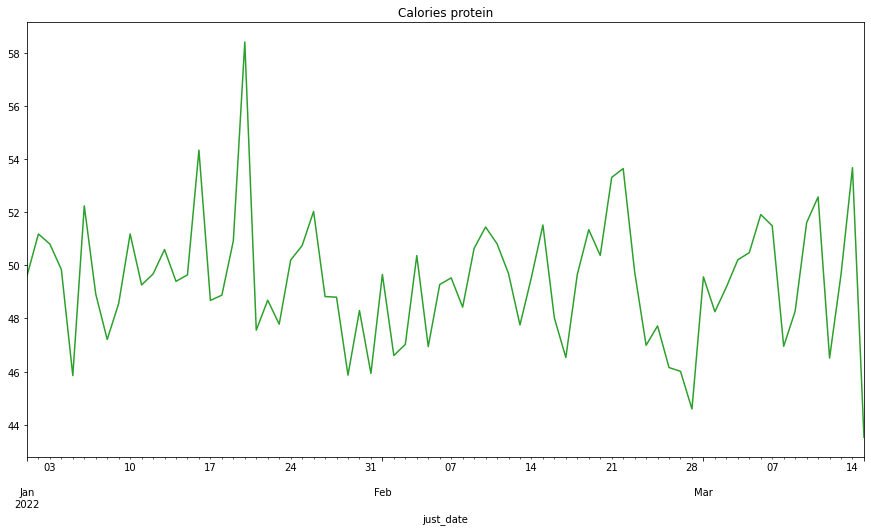

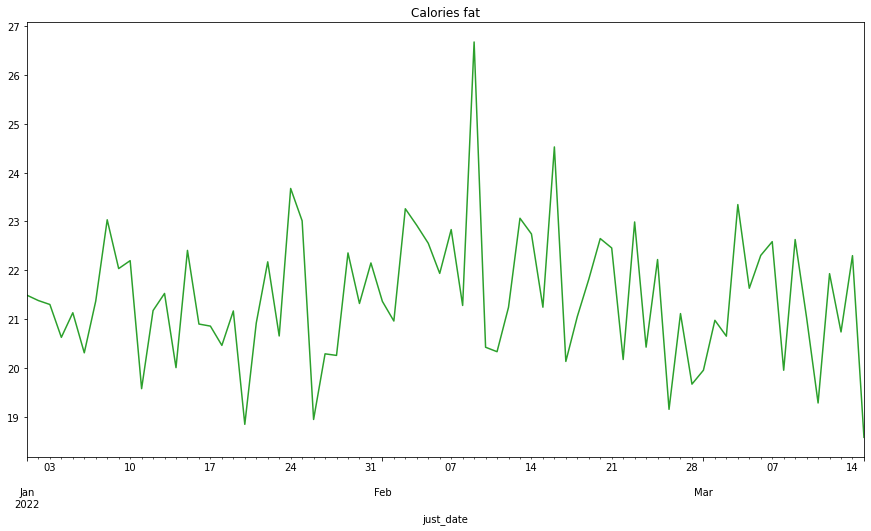

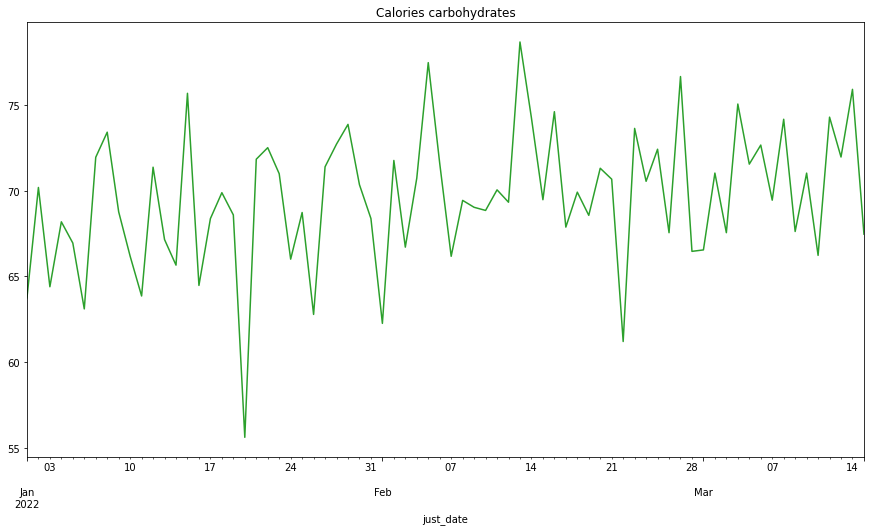

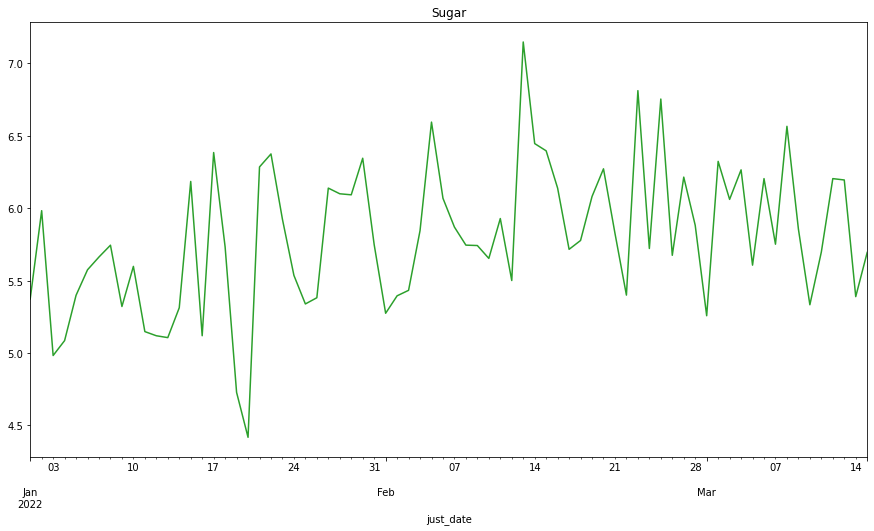

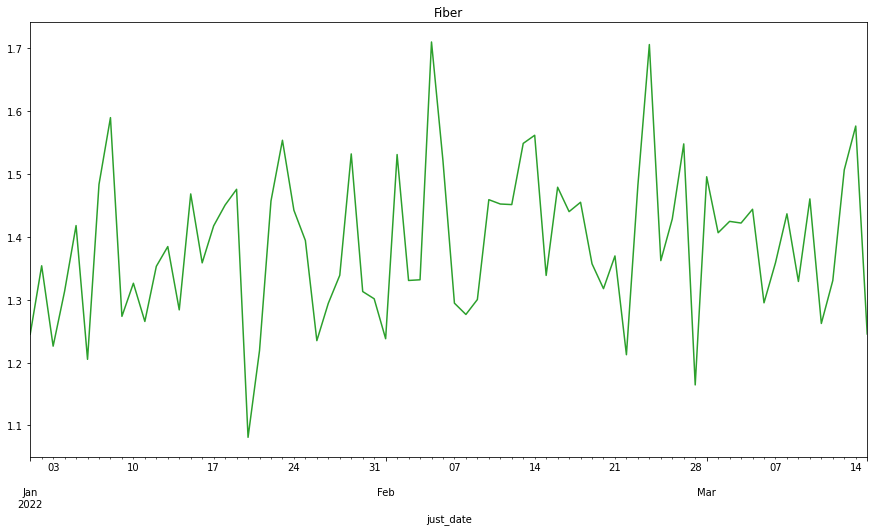

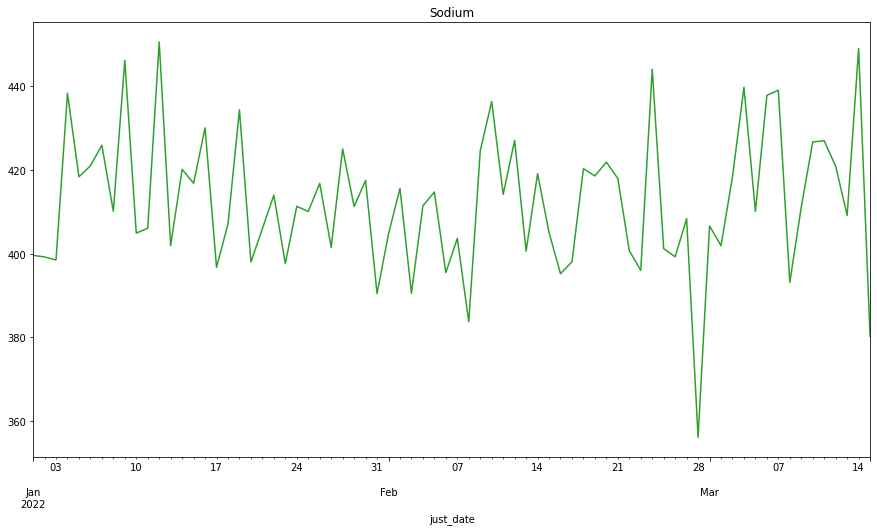

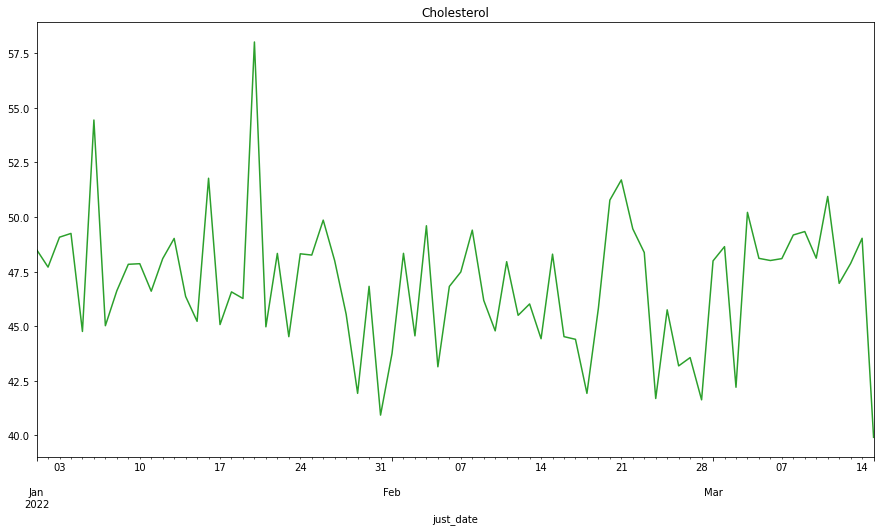

In [54]:
plot_all_nutritional_values(df_combined_2022, 'D', 'tab:green')

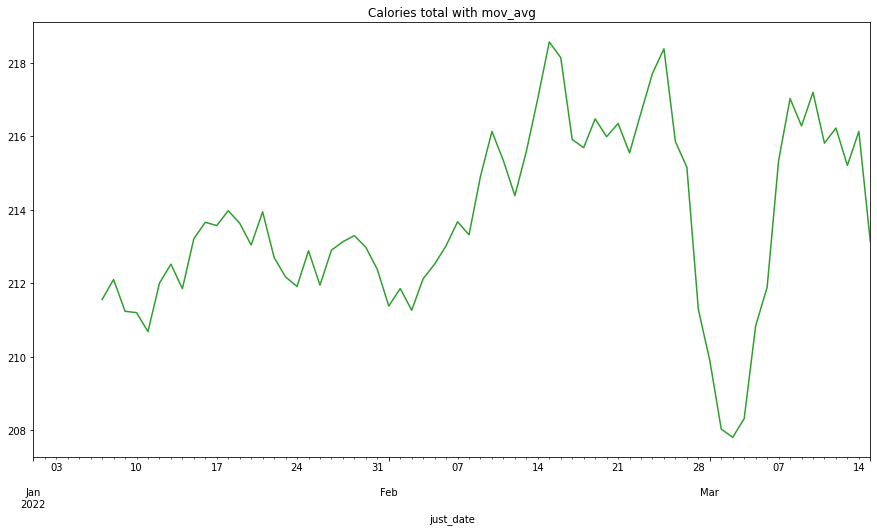

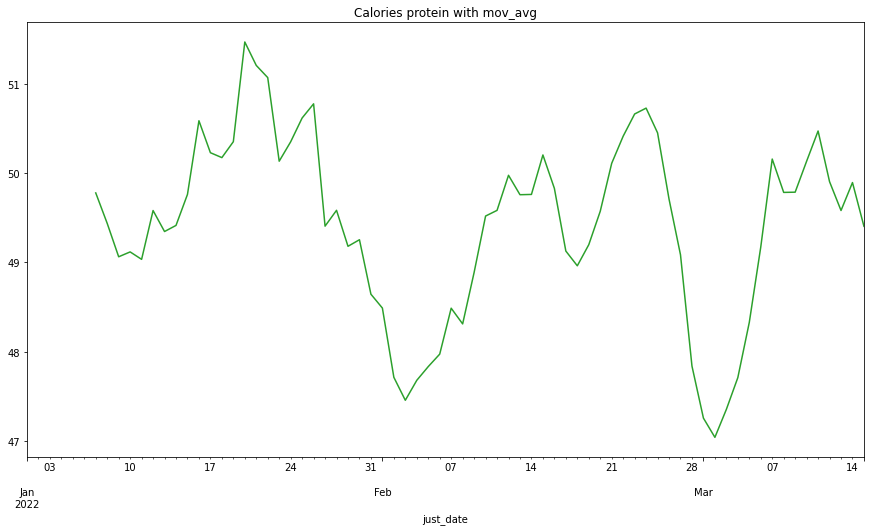

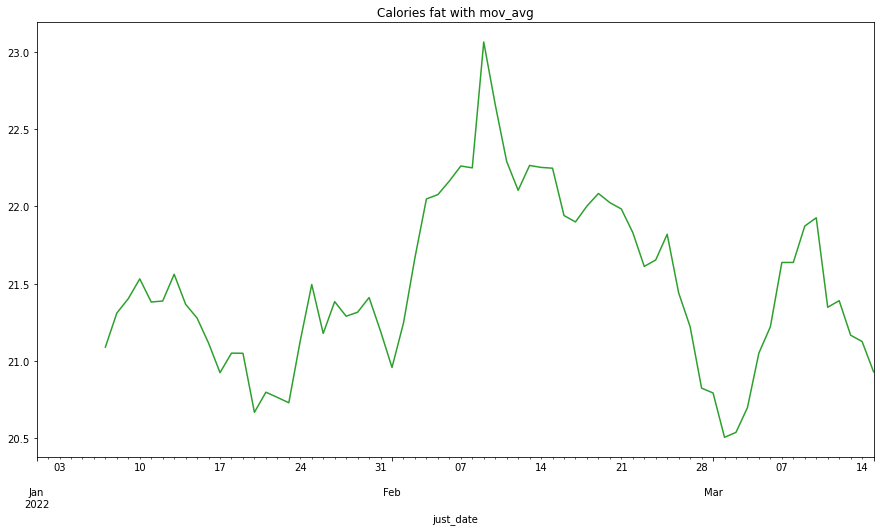

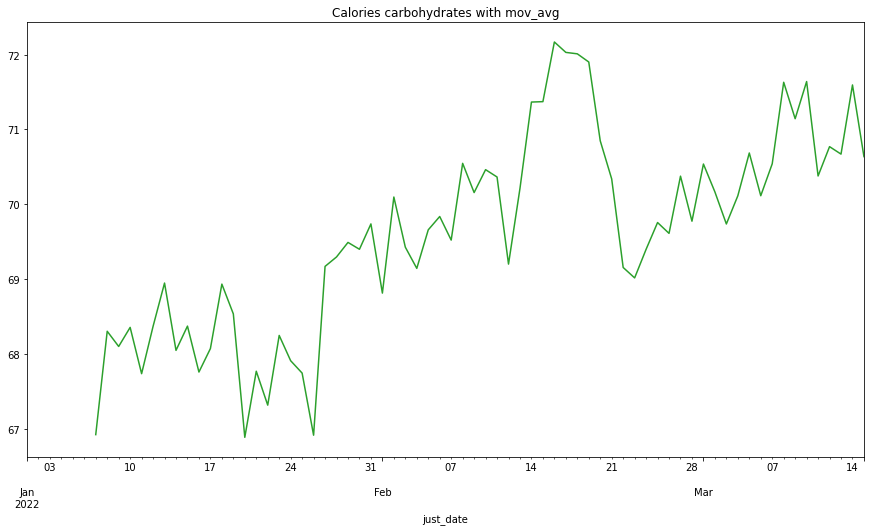

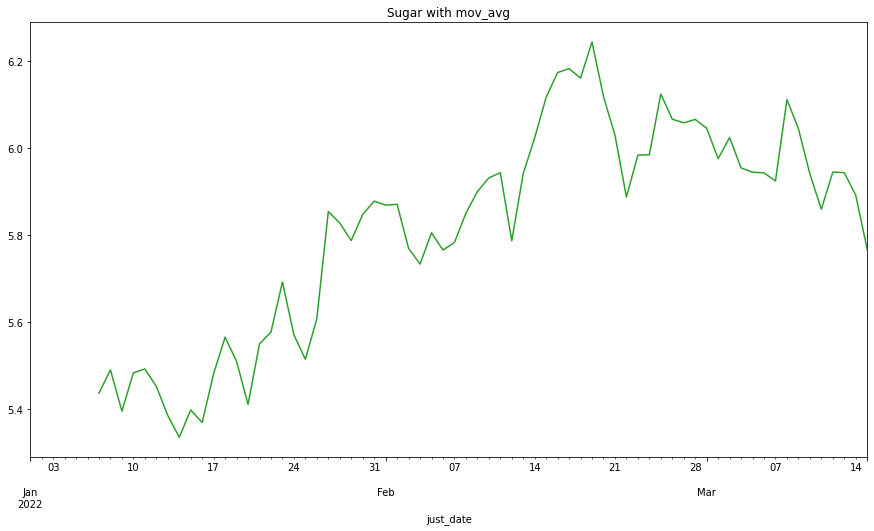

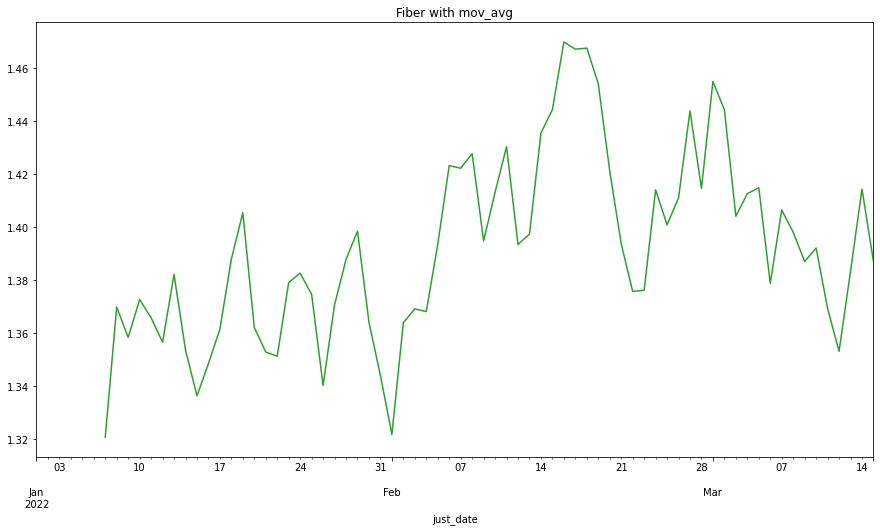

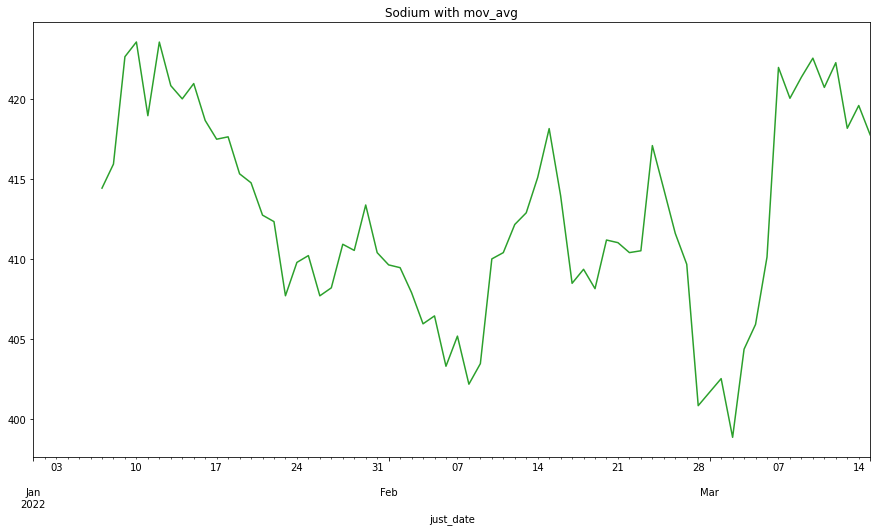

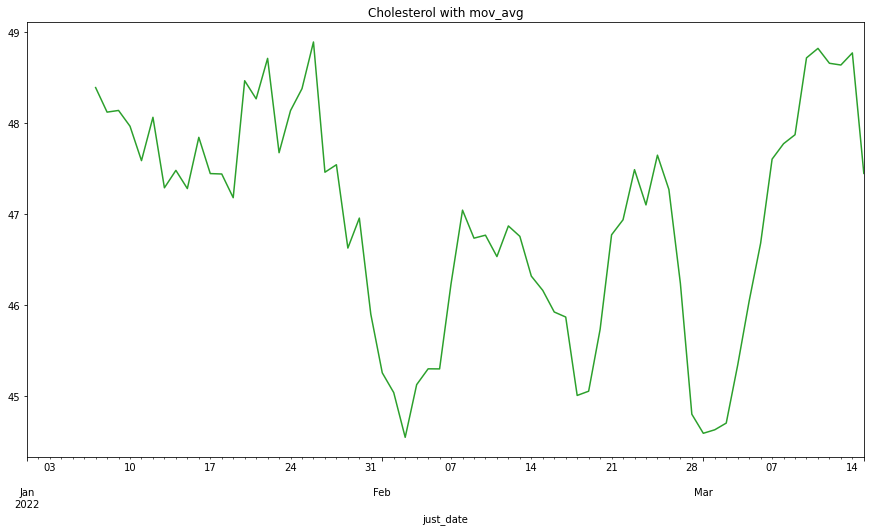

In [55]:
plot_all_nutritional_values_with_moving_average(df_combined_2022, 'D', 'tab:green', 7)

In [56]:
txt_file = pd.read_csv('food_submissions_pretty.txt', delimiter='\t')

C:\Users\melik\AppData\Local\Temp\ipykernel_27428\448192318.py:1: DtypeWarning: Columns (2,6,8,16) have mixed types. Specify dtype option on import or set low_memory=False.
  txt_file = pd.read_csv('food_submissions_pretty.txt', delimiter='\t')


In [57]:
txt_file.head()

subredditId subreddit  created_at     author author_flair_text  \
0    t5_2qh55      food  1201387244  [deleted]              None   
1    t5_2qh55      food  1201506131  [deleted]              None   
2    t5_2qh55      food  1201534176  [deleted]              None   
3    t5_2qh55      food  1201546089  [deleted]              None   
4    t5_2qh55      food  1201558573  [deleted]              None   

  author_flair_css_class num_comments  \
0                   None            0   
1                   None            0   
2                   None            1   
3                   None            0   
4                   None            0   

                                                 url score  \
0              http://findveganrecipes.blogspot.com/     2   
1                               http://www.chow.com/     2   
2                           http://www.foodtube.net/     1   
3  http://www.ediblecommunities.com/portal/edible...     1   
4  http://www.youtube.com/profile?user=Manjulaski...     2   

  link_flair_css_class link_flair_text  \
0                 None            None   
1                 None            None   
2                 None            None   
3                 None            None   
4                 None            None   

                                               title   selftext  \
0                           Find recipes (all vegan)  [deleted]   
1  CHOW - Recipes, cooking tips, resources, and s...        NaN   
2                                       FoodTube.net        NaN   
3                                Edible Publications        NaN   
4                YouTube - Manjulaskitchen's Channel        NaN   

                                                link removed_by mod_removed  \
0     /r/food/comments/66puj/find_recipes_all_vegan/       None        None   
1  /r/food/comments/66tyf/chow_recipes_cooking_ti...       None        None   
2                /r/food/comments/66v4h/foodtubenet/       None        None   
3        /r/food/comments/66vz4/edible_publications/       None        None   
4  /r/food/comments/66wu0/youtube_manjulaskitchen...       None        None   

  user_removed  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN

In [58]:
def return_timestamp(dtt):
    curr_dt_1 = pd.to_datetime(dtt)
    final_timestamp = 1e9 * curr_dt_1.second + 1e3 * curr_dt_1.microsecond + curr_dt_1.nanosecond
    actual_date = pd.to_datetime(final_timestamp, unit='s')
    return actual_date

In [103]:
txt_file = txt_file.dropna(subset=['created_at'])

In [129]:
txt_file = txt_file[txt_file['created_at'] != 'image']

In [130]:
txt_file['created_at'] = txt_file['created_at'].apply(lambda x: int(float(x)))

In [131]:
txt_file.head()

subredditId subreddit  created_at     author author_flair_text  \
0    t5_2qh55      food  1201387244  [deleted]              None   
1    t5_2qh55      food  1201506131  [deleted]              None   
2    t5_2qh55      food  1201534176  [deleted]              None   
3    t5_2qh55      food  1201546089  [deleted]              None   
4    t5_2qh55      food  1201558573  [deleted]              None   

  author_flair_css_class num_comments  \
0                   None            0   
1                   None            0   
2                   None            1   
3                   None            0   
4                   None            0   

                                                 url score  \
0              http://findveganrecipes.blogspot.com/     2   
1                               http://www.chow.com/     2   
2                           http://www.foodtube.net/     1   
3  http://www.ediblecommunities.com/portal/edible...     1   
4  http://www.youtube.com/profile?user=Manjulaski...     2   

  link_flair_css_class link_flair_text  \
0                 None            None   
1                 None            None   
2                 None            None   
3                 None            None   
4                 None            None   

                                               title   selftext  \
0                           Find recipes (all vegan)  [deleted]   
1  CHOW - Recipes, cooking tips, resources, and s...        NaN   
2                                       FoodTube.net        NaN   
3                                Edible Publications        NaN   
4                YouTube - Manjulaskitchen's Channel        NaN   

                                                link removed_by mod_removed  \
0     /r/food/comments/66puj/find_recipes_all_vegan/       None        None   
1  /r/food/comments/66tyf/chow_recipes_cooking_ti...       None        None   
2                /r/food/comments/66v4h/foodtubenet/       None        None   
3        /r/food/comments/66vz4/edible_publications/       None        None   
4  /r/food/comments/66wu0/youtube_manjulaskitchen...       None        None   

  user_removed   type_of_date  
0          NaN  <class 'int'>  
1          NaN  <class 'int'>  
2          NaN  <class 'int'>  
3          NaN  <class 'int'>  
4          NaN  <class 'int'>

In [132]:
txt_file['datetime'] = txt_file['created_at'].map(lambda t: dt.datetime.fromtimestamp(t))

In [134]:
txt_file = txt_file.drop(['subredditId', 'subreddit', 'author', 'author_flair_css_class', 'created_at', 'author_flair_text', 'num_comments', 'url', 'score', 'link_flair_css_class', 'link_flair_text', 'selftext', 'link', 'removed_by', 'mod_removed', 'user_removed','type_of_date' ], axis = 1)

In [165]:
txt_file['just_date'] = txt_file['datetime'].apply(lambda x: str(x)[:10])

In [166]:
txt_file.head()

title            datetime  \
0                           Find recipes (all vegan) 2008-01-26 23:40:44   
1  CHOW - Recipes, cooking tips, resources, and s... 2008-01-28 08:42:11   
2                                       FoodTube.net 2008-01-28 16:29:36   
3                                Edible Publications 2008-01-28 19:48:09   
4                YouTube - Manjulaskitchen's Channel 2008-01-28 23:16:13   

    just_date  
0  2008-01-26  
1  2008-01-28  
2  2008-01-28  
3  2008-01-28  
4  2008-01-28

In [162]:
df_combined_2.head()

food_post_title      food_post_date  \
1  poached eggs bacon mushrooms toasted sourdough... 2019-09-29 16:01:41   
2                                spicy miso tsukemen 2019-09-29 16:02:26   
3                 single serve sugar baby watermelon 2019-09-29 16:02:31   
4             chocolate chip cookie dough cheesecake 2019-09-29 16:03:06   
5             chocolate chip cookie dough cheesecake 2019-09-29 16:05:40   

                             closest_match_from_usda    protein        fat  \
1  [Barracuda  steamed or poached, Carp  steamed ...  19.196491   1.464982   
2  [Soybean soup  miso broth, Cheese  goat  semis...  12.035000  15.212500   
3  [Fast foods  cheeseburger  single  large patty...   8.543636   2.021864   
4  [Muffin  chocolate chip, Cookie  chocolate chi...   7.395870   6.511587   
5  [Muffin  chocolate chip, Cookie  chocolate chi...   7.395870   6.511587   

       sugar  carbohydrates      sodium  cholesterol     fiber  protein_cals  \
1   1.004912       7.418070  496.701754    82.385965  0.438596     76.864912   
2   0.505000       1.295000  512.500000    41.500000  0.200000     51.056000   
3  10.293333      18.650227  280.454545    22.590909  0.962791     34.370636   
4  26.244000      51.198478  464.239130    19.444444  1.823256     28.762870   
5  26.244000      51.198478  464.239130    19.444444  1.823256     28.762870   

     fat_cals   carb_cals                              index_of_usda_in_json  \
1   13.185933   29.668295  [1263, 1270, 1288, 1305, 1315, 1317, 1336, 134...   
2  133.783500    5.172200                                      [2961, 13004]   
3   17.456117   74.363318  [9865, 10261, 10262, 10263, 10264, 10265, 1028...   
4   57.230130  201.057391  [3356, 3460, 3461, 3462, 3463, 3494, 3504, 354...   
5   57.230130  201.057391  [3356, 3460, 3461, 3462, 3463, 3494, 3504, 354...   

     calories  list_len   just_date  
1  183.433158        57  2019-09-29  
2  198.145000         2  2019-09-29  
3  183.341136        44  2019-09-29  
4  386.065435        46  2019-09-29  
5  386.065435        46  2019-09-29

In [160]:
str(df_combined_2['food_post_date'].iloc[0])[:10]#.date()

'2019-09-29'

In [226]:
df_combined_2['just_date'] = df_combined_2['food_post_date'].apply(lambda x: str(x)[:10])

C:\Users\melik\AppData\Local\Temp\ipykernel_1528\3174387927.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined_2['just_date'] = df_combined_2['food_post_date'].apply(lambda x: str(x)[:10])


In [227]:
df_combined_2_1.head()

food_post_title  \
just_date                                                       
2019-09-29  poached eggs bacon mushrooms toasted sourdough...   
2019-09-29                                spicy miso tsukemen   
2019-09-29                 single serve sugar baby watermelon   
2019-09-29             chocolate chip cookie dough cheesecake   
2019-09-29             chocolate chip cookie dough cheesecake   

                food_post_date  \
just_date                        
2019-09-29 2019-09-29 16:01:41   
2019-09-29 2019-09-29 16:02:26   
2019-09-29 2019-09-29 16:02:31   
2019-09-29 2019-09-29 16:03:06   
2019-09-29 2019-09-29 16:05:40   

                                      closest_match_from_usda    protein  \
just_date                                                                  
2019-09-29  [Barracuda  steamed or poached, Carp  steamed ...  19.196491   
2019-09-29  [Soybean soup  miso broth, Cheese  goat  semis...  12.035000   
2019-09-29  [Fast foods  cheeseburger  single  large patty...   8.543636   
2019-09-29  [Muffin  chocolate chip, Cookie  chocolate chi...   7.395870   
2019-09-29  [Muffin  chocolate chip, Cookie  chocolate chi...   7.395870   

                  fat      sugar  carbohydrates      sodium  cholesterol  \
just_date                                                                  
2019-09-29   1.464982   1.004912       7.418070  496.701754    82.385965   
2019-09-29  15.212500   0.505000       1.295000  512.500000    41.500000   
2019-09-29   2.021864  10.293333      18.650227  280.454545    22.590909   
2019-09-29   6.511587  26.244000      51.198478  464.239130    19.444444   
2019-09-29   6.511587  26.244000      51.198478  464.239130    19.444444   

               fiber  protein_cals    fat_cals   carb_cals  \
just_date                                                    
2019-09-29  0.438596     76.864912   13.185933   29.668295   
2019-09-29  0.200000     51.056000  133.783500    5.172200   
2019-09-29  0.962791     34.370636   17.456117   74.363318   
2019-09-29  1.823256     28.762870   57.230130  201.057391   
2019-09-29  1.823256     28.762870   57.230130  201.057391   

                                        index_of_usda_in_json    calories  \
just_date                                                                   
2019-09-29  [1263, 1270, 1288, 1305, 1315, 1317, 1336, 134...  183.433158   
2019-09-29                                      [2961, 13004]  198.145000   
2019-09-29  [9865, 10261, 10262, 10263, 10264, 10265, 1028...  183.341136   
2019-09-29  [3356, 3460, 3461, 3462, 3463, 3494, 3504, 354...  386.065435   
2019-09-29  [3356, 3460, 3461, 3462, 3463, 3494, 3504, 354...  386.065435   

            list_len  
just_date             
2019-09-29        57  
2019-09-29         2  
2019-09-29        44  
2019-09-29        46  
2019-09-29        46

In [228]:
# Setting the Date values as index
df_combined_2_1 = df_combined_2.set_index('just_date')
 
# to_datetime() method converts string
# format to a DateTime object
df_combined_2_1.index = pd.to_datetime(df_combined_2_1.index)
 
# dates which are not in the sequence
# are returned
print(pd.date_range(
  start="2018-03-15", end="2022-03-16").difference(df_combined_2_1.index))

DatetimeIndex(['2018-03-31', '2018-04-30', '2018-05-31', '2018-06-30',
               '2018-07-31', '2018-08-31', '2018-09-30', '2018-10-31',
               '2018-11-30', '2018-12-31', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
               '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31',
               '2020-03-31', '2020-04-30', '2020-05-31', '2020-06-30',
               '2020-07-31', '2020-08-31', '2020-09-30', '2020-10-31',
               '2020-11-30', '2020-12-31', '2021-03-31', '2021-04-30',
               '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31',
               '2021-09-30', '2021-10-31', '2021-11-30', '2021-12-31',
               '2022-01-31', '2022-02-28', '2022-03-15', '2022-03-16'],
              dtype='datetime64[ns]', freq=None)


In [185]:
list_of_missing_dates = [['2018-03-31', '2019-02-01'], 
                         ['2018-04-30', '2019-03-01'], 
                         ['2020-01-31', '2020-02-01'], 
                         ['2020-02-29', '2020-03-01'],
                         ['2021-01-31', '2021-02-01'], 
                         ['2021-02-05', '2021-02-08'], 
                         ['2021-02-28', '2021-03-02'],
                         ['2021-03-06', '2021-03-07'],
                         ['2021-03-18', '2021-03-27'],
                         ['2021-04-10', '2021-04-14']
                         ]

In [186]:
txt_file.head()

title            datetime  \
0                           Find recipes (all vegan) 2008-01-26 23:40:44   
1  CHOW - Recipes, cooking tips, resources, and s... 2008-01-28 08:42:11   
2                                       FoodTube.net 2008-01-28 16:29:36   
3                                Edible Publications 2008-01-28 19:48:09   
4                YouTube - Manjulaskitchen's Channel 2008-01-28 23:16:13   

    just_date  
0  2008-01-26  
1  2008-01-28  
2  2008-01-28  
3  2008-01-28  
4  2008-01-28

In [187]:
list_of_dataframes = []

In [188]:
for start_date, end_date in list_of_missing_dates:
    df_tmp = txt_file[txt_file['just_date'] >= start_date]
    print('len df_tmp: ' + str(len(df_tmp)))
    df_tmp = df_tmp[df_tmp['just_date'] < end_date]
    print('len df_tmp: ' + str(len(df_tmp)))
    
    list_of_dataframes.append(df_tmp)

len df_tmp: 506465
len df_tmp: 492
len df_tmp: 491119
len df_tmp: 491
len df_tmp: 313773
len df_tmp: 578
len df_tmp: 295848
len df_tmp: 621
len df_tmp: 71258
len df_tmp: 752
len df_tmp: 68106
len df_tmp: 1889
len df_tmp: 54149
len df_tmp: 1158
len df_tmp: 51025
len df_tmp: 577
len df_tmp: 44512
len df_tmp: 4320
len df_tmp: 33775
len df_tmp: 1785


In [190]:
list_of_dataframes

[                                                    title            datetime  \
 814157  البقلاوه واسرار جمالها بابسط الطرق#حلويات سهله... 2019-01-31 00:01:15   
 814158             [Homemade] Fruity Pebble Krispie Treat 2019-01-31 00:04:30   
 814159  [Homemade] Pan-fried ricotta gnocchi with a ga... 2019-01-31 00:06:58   
 814160                                              Yummy 2019-01-31 00:08:31   
 814161                 [homemade] Chanko-nabe, sumo stew! 2019-01-31 00:09:11   
 ...                                                   ...                 ...   
 814644                           [I Ate] Chinese Pig Ears 2019-01-31 23:45:20   
 814645           Everyone’s forgot the McFlurry. I think. 2019-01-31 23:50:14   
 814646                               [homemade] hot Honey 2019-01-31 23:50:17   
 814647                  [Homemade] Big Mac Style Hot Dogs 2019-01-31 23:50:53   
 814648                             Oh boy what flavor !!! 2019-01-31 23:57:13   
 
          just

In [194]:
df_new = pd.concat(list_of_dataframes, axis=0)

In [195]:
len(df_new)

12663

In [196]:
df_new.head()

title            datetime  \
814157  البقلاوه واسرار جمالها بابسط الطرق#حلويات سهله... 2019-01-31 00:01:15   
814158             [Homemade] Fruity Pebble Krispie Treat 2019-01-31 00:04:30   
814159  [Homemade] Pan-fried ricotta gnocchi with a ga... 2019-01-31 00:06:58   
814160                                              Yummy 2019-01-31 00:08:31   
814161                 [homemade] Chanko-nabe, sumo stew! 2019-01-31 00:09:11   

         just_date  
814157  2019-01-31  
814158  2019-01-31  
814159  2019-01-31  
814160  2019-01-31  
814161  2019-01-31

In [197]:
df_new.to_csv('missing_data_from_dumps.csv')